## Lung Cancer Mortality Classifier

This notebook explores a dataset of lung cancer patients with the goal of predicting patient mortality. By applying machine learning techniques, I aim to identify key factors that influence survival outcomes and develop a model capable of accurately classifying mortality risk.

### Dataset

Dataset from: https://www.kaggle.com/datasets/khwaishsaxena/lung-cancer-dataset

In [144]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style and palette
sns.set_style('darkgrid')
sns.set_palette("colorblind")

# sklearn - model selection
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_val_score,
)

# sklearn - preprocessing
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
)

# sklearn - imputation
from sklearn.impute import SimpleImputer

# sklearn - models
from sklearn.ensemble import (
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_recall_curve,
    roc_curve,
    auc,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

# imblearn - sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# specialized models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


#### Load Dataset into pandas dataframe

In [77]:
df = pd.read_csv('LungCancer.csv')
df = df.drop('id', axis = 1)
df.head()

,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0


#### Exploratory Data Analysis

The goal of this section is to,

1. Understand the Structure of the data
    - df.shape
    - df.info
    - df.describe
2. View missing values
    - df.isna().sum()
    - Consider if missing values may be informative (e.g., "missing" could imply "not applicable").
4. Conduct Univariate Analysis of features
    - Numeric Feature
        - histograms
        - boxplots
        - violinplots
    - Categoric Features
        - count plot 
6. Conduct Bivariate Analysis
    - Numeric vs Numeric features
        - scatterplots
    - Numeric vs Categorical features
        - boxplots
        - violin plots
    - Categoric vs Categoric features
        - cross tabs

In [12]:
df.shape

(890000, 16)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890000 entries, 0 to 889999
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   age                 890000 non-null  float64
 1   gender              890000 non-null  object 
 2   country             890000 non-null  object 
 3   diagnosis_date      890000 non-null  object 
 4   cancer_stage        890000 non-null  object 
 5   family_history      890000 non-null  object 
 6   smoking_status      890000 non-null  object 
 7   bmi                 890000 non-null  float64
 8   cholesterol_level   890000 non-null  int64  
 9   hypertension        890000 non-null  int64  
 10  asthma              890000 non-null  int64  
 11  cirrhosis           890000 non-null  int64  
 12  other_cancer        890000 non-null  int64  
 13  treatment_type      890000 non-null  object 
 14  end_treatment_date  890000 non-null  object 
 15  survived            890000 non-nul

In [14]:
df.describe()

,age,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,survived
count,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000
mean,55.007008,30.494172,233.633916,0.750024,0.469740,0.225956,0.088157,0.220229
std,9.994485,8.368539,43.432278,0.432999,0.499084,0.418211,0.283524,0.414401
min,4.000000,16.000000,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,23.300000,196.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,30.500000,242.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,62.000000,37.700000,271.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,104.000000,45.000000,300.000000,1.000000,1.000000,1.000000,1.000000,1.000000


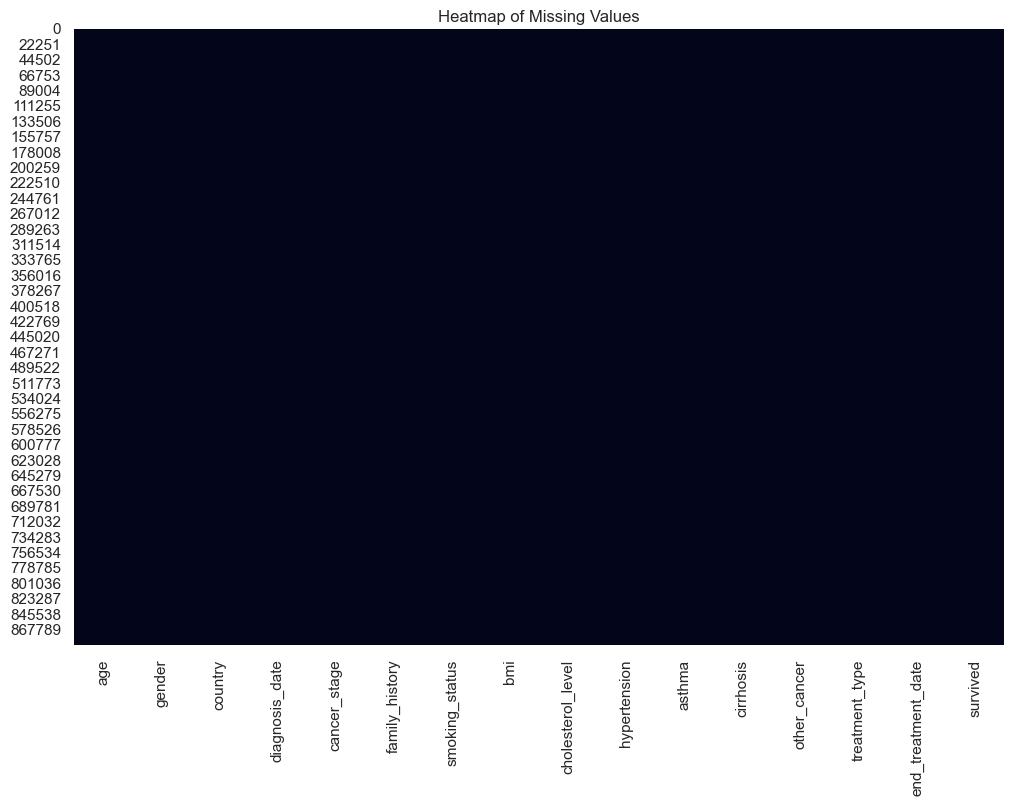

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isna(),cbar = False)
plt.title(f"Heatmap of Missing Values")
plt.show()

So as we can see our dataset contains no missing values, no lets move onto the univariate analysis section

In [16]:
def plot_univariate(df, features):
    sns.set_theme(style="whitegrid", palette="colorblind")
    sns.set_context("notebook")

    for feature in features:
        dtype = df[feature].dtype

        if dtype == 'int64' or dtype == 'float64':
            plt.figure(figsize=(15, 5))

            # Histogram with KDE
            plt.subplot(1, 3, 1)
            sns.histplot(data=df, x=feature, kde=True, bins=30, color="skyblue")
            plt.title(f"Histogram of {feature}", fontsize=12)
            plt.xlabel(feature)
            plt.ylabel("Frequency")

            # Boxplot (horizontal for better readability)
            plt.subplot(1, 3, 2)
            sns.boxplot(data=df, x=feature, color="lightgreen", showfliers=True)
            plt.title(f"Boxplot of {feature}", fontsize=12)

            # Violin plot
            plt.subplot(1, 3, 3)
            sns.violinplot(data=df, x=feature, color="lightcoral")
            plt.title(f"Violin Plot of {feature}", fontsize=12)

            sns.despine()
            plt.tight_layout()
            plt.show()

        else:
            plt.figure(figsize=(10, 6))
            sns.countplot(data=df, x=feature, order=df[feature].value_counts().index, palette = 'pastel', hue = feature)
            plt.title(f"Countplot of {feature}", fontsize=12)
            plt.xticks(rotation=45)
            plt.ylabel("Count")
            sns.despine()
            plt.tight_layout()
            plt.show()


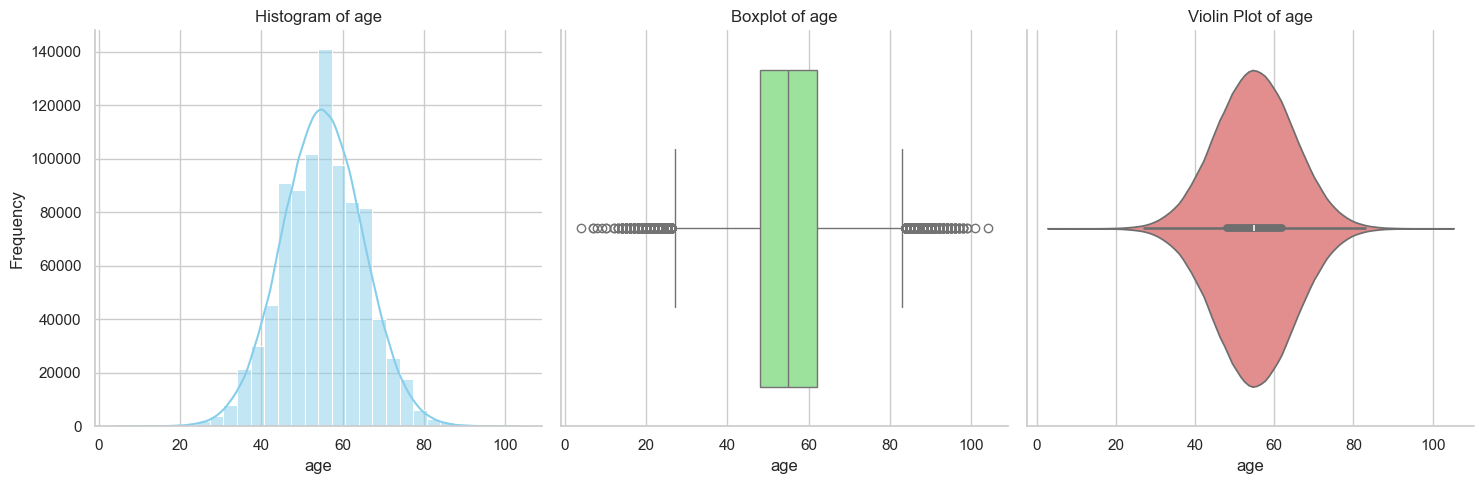

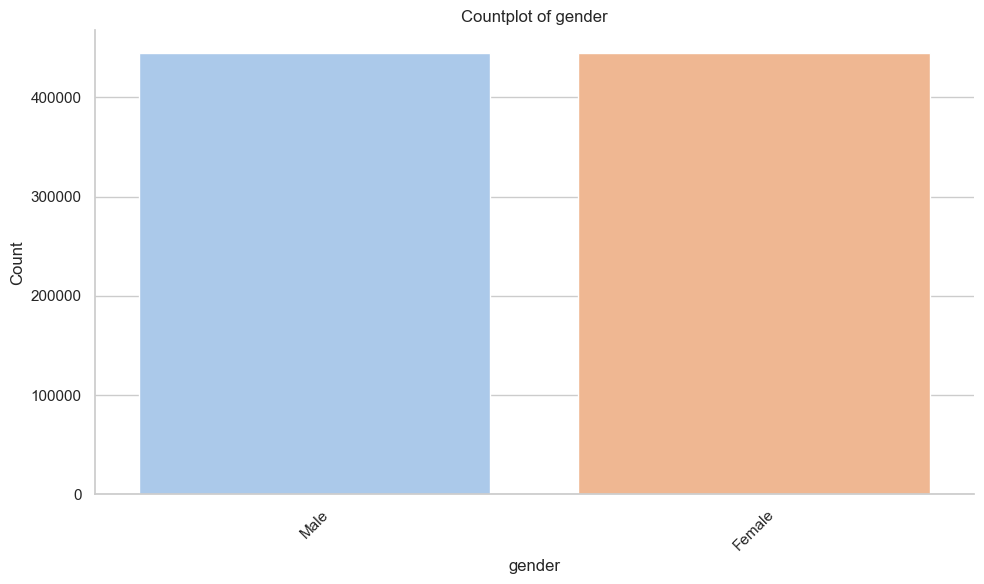

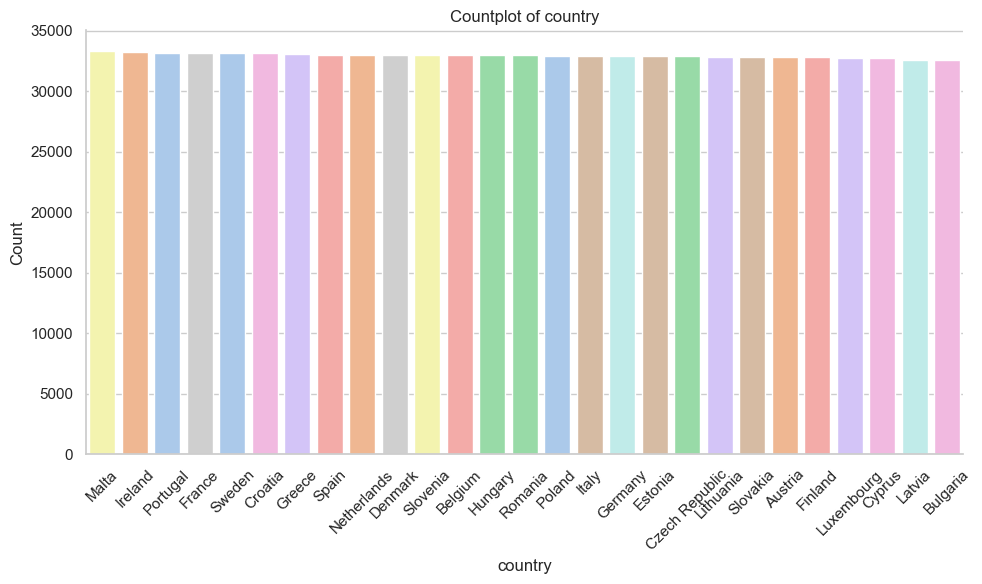

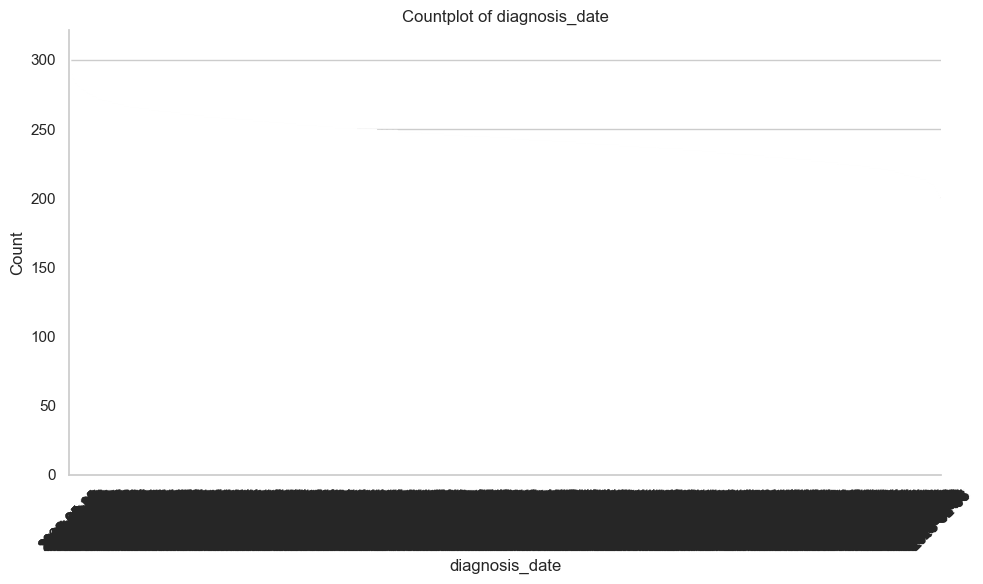

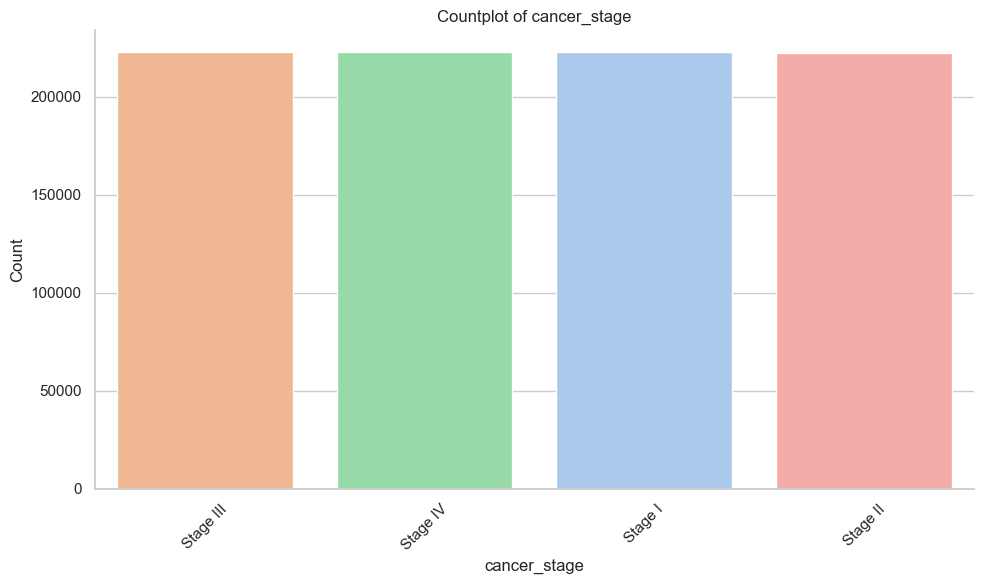

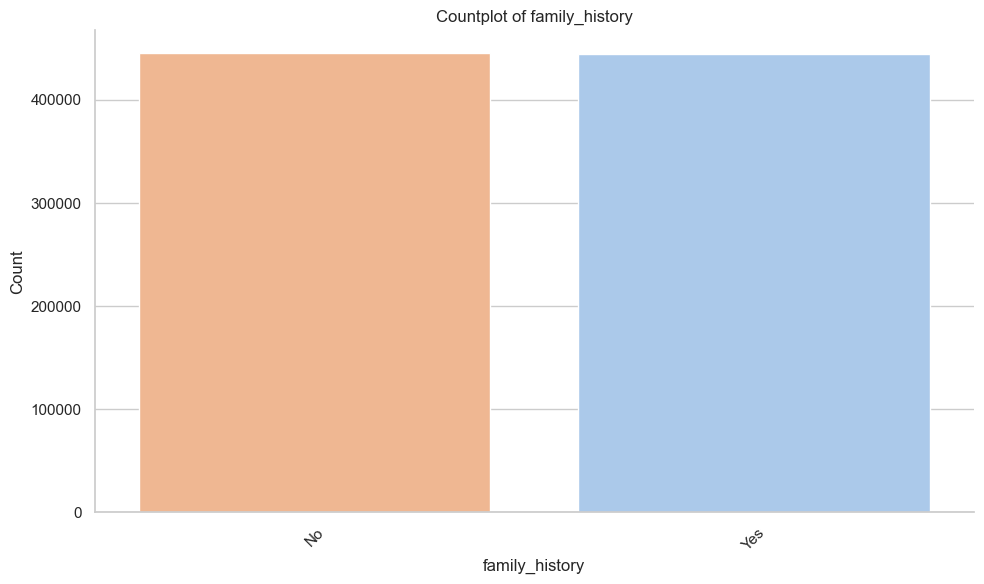

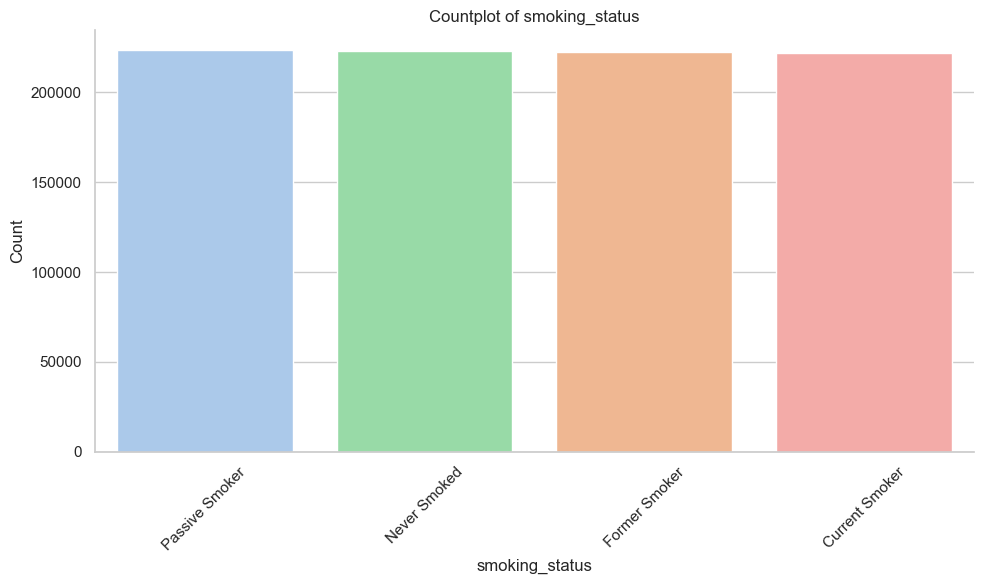

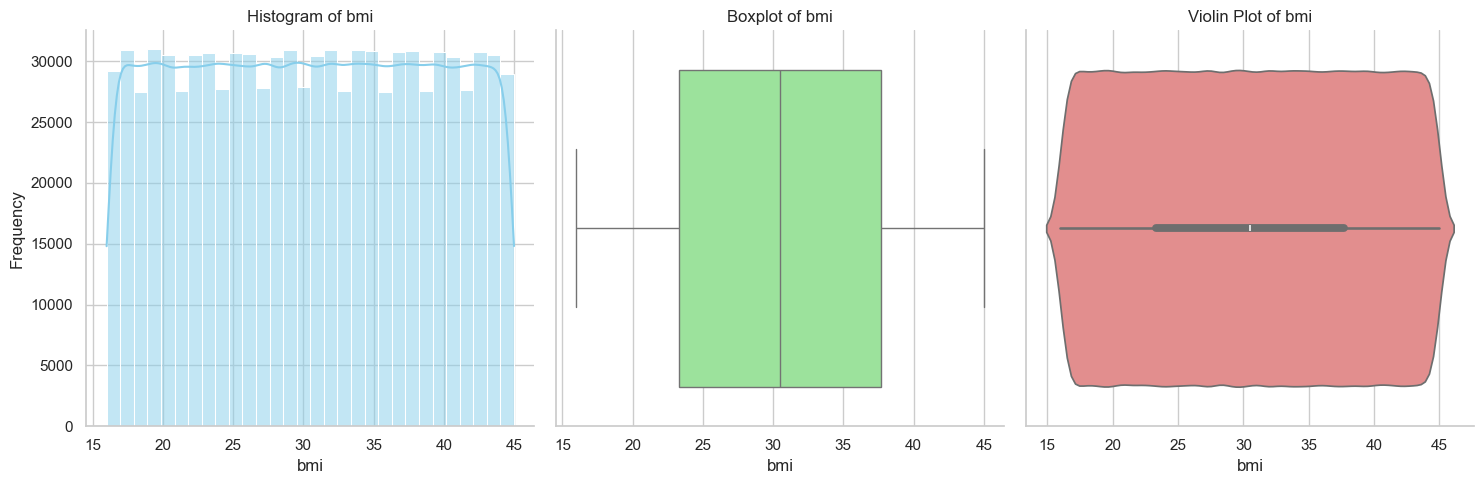

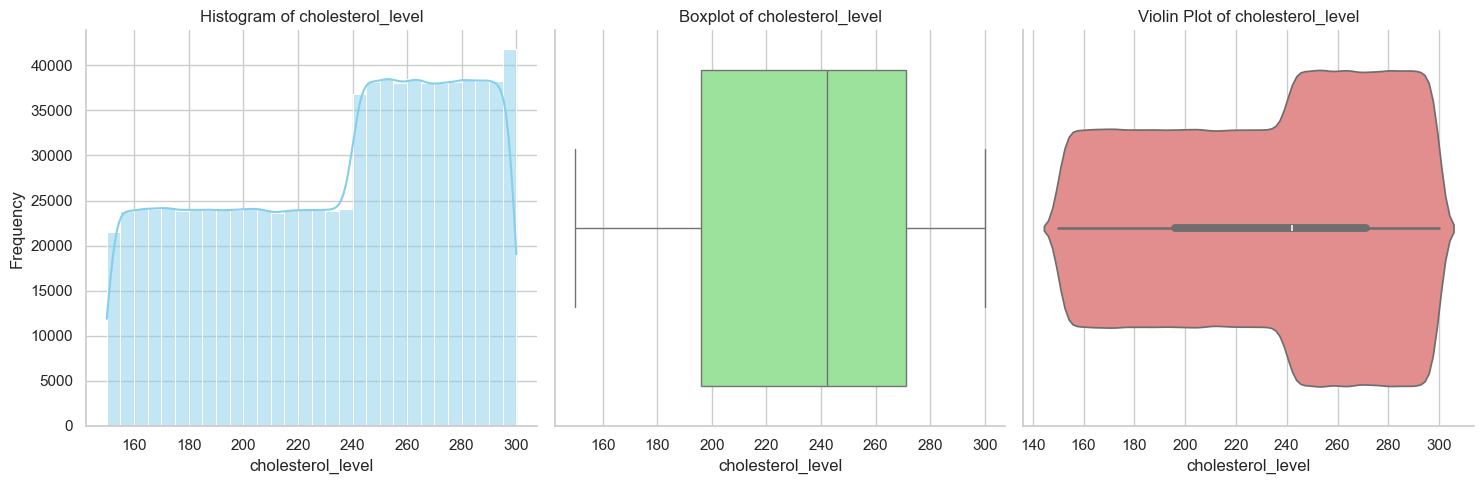

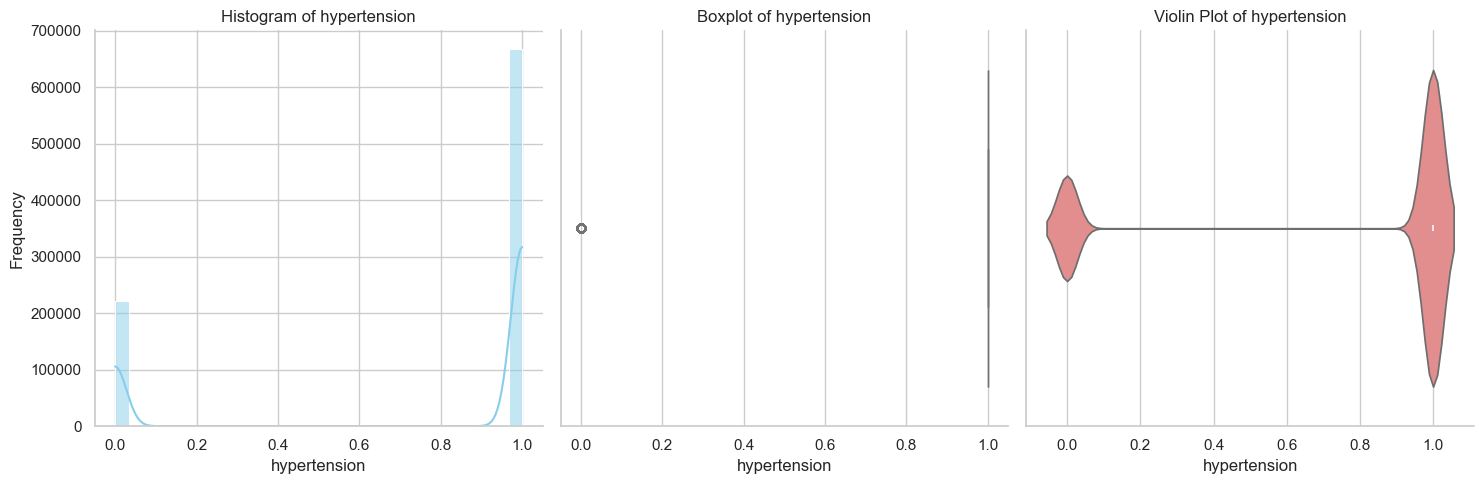

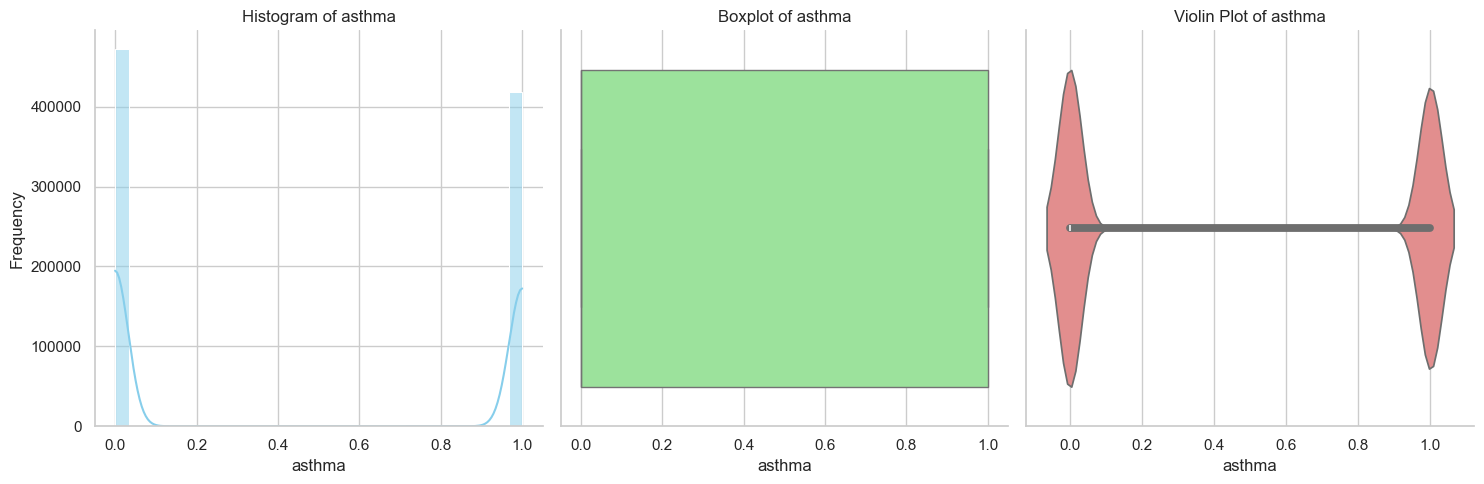

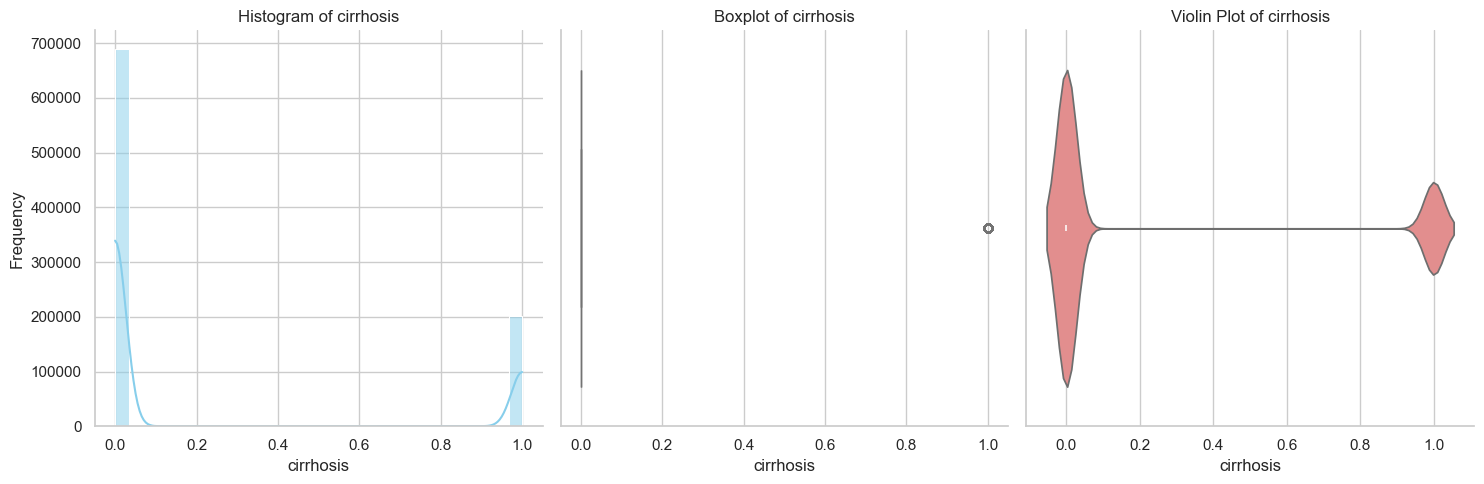

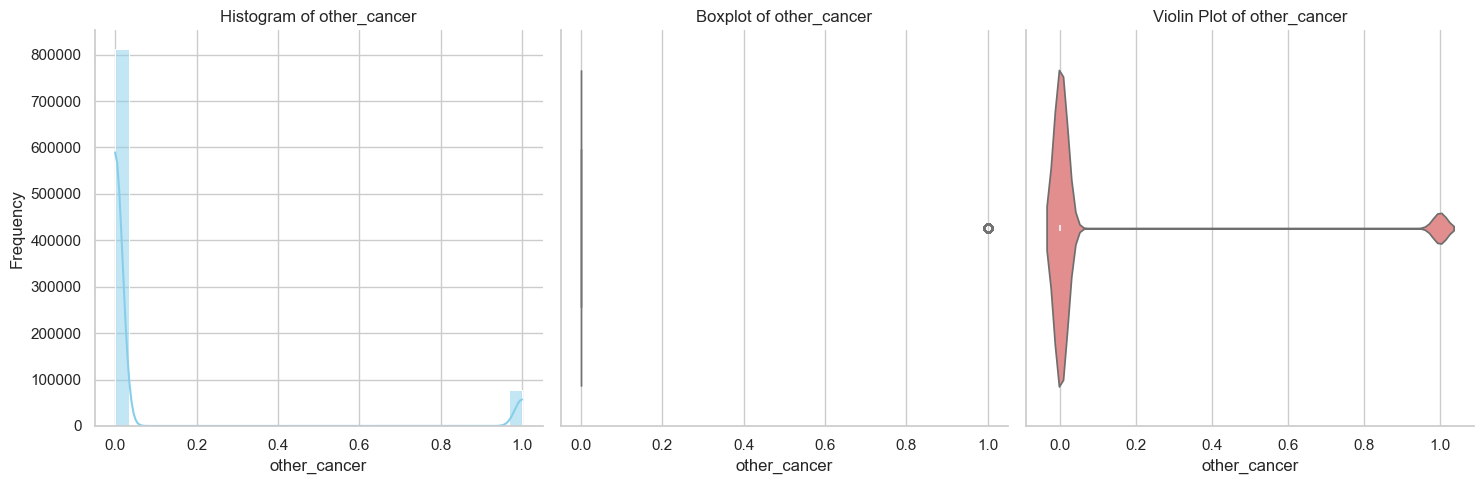

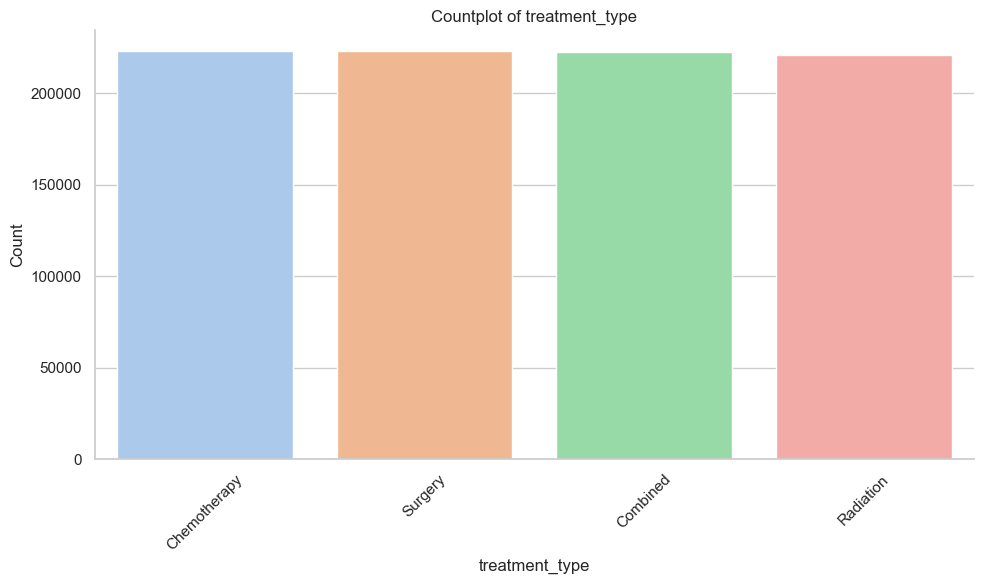

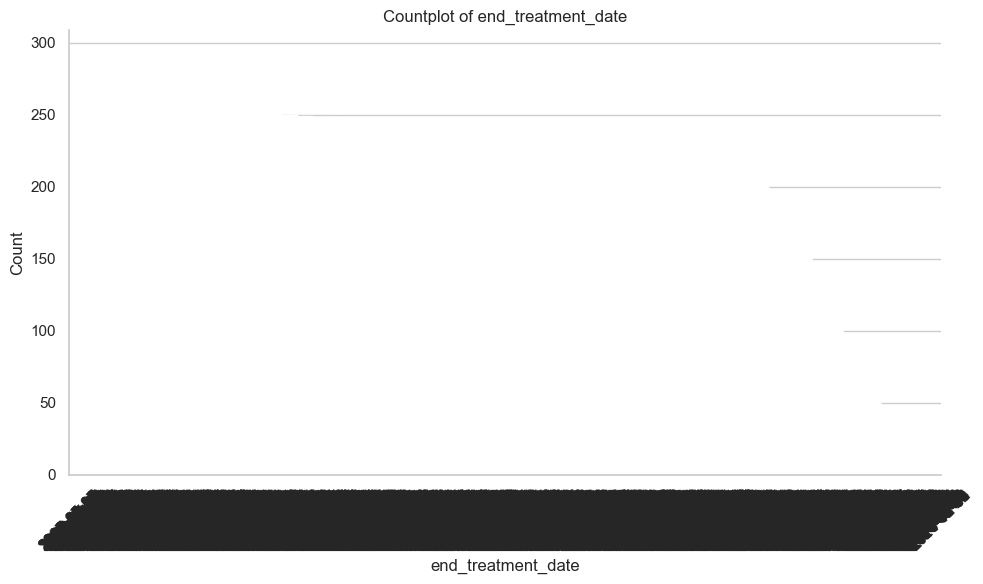

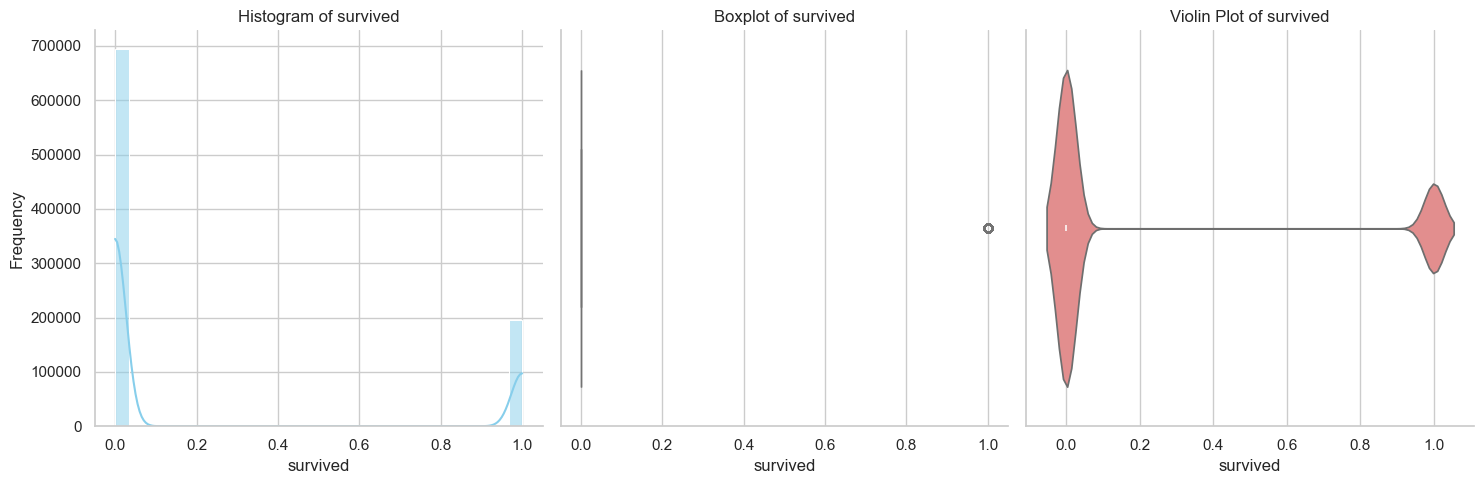

In [17]:
features = df.columns
plot_univariate(df, features)

### Univariate Analysis

Age: The distribution of age is quite normal, but with many outliers.
Gender: The distribution of gender is equal
Country: The distribution of countries is equal

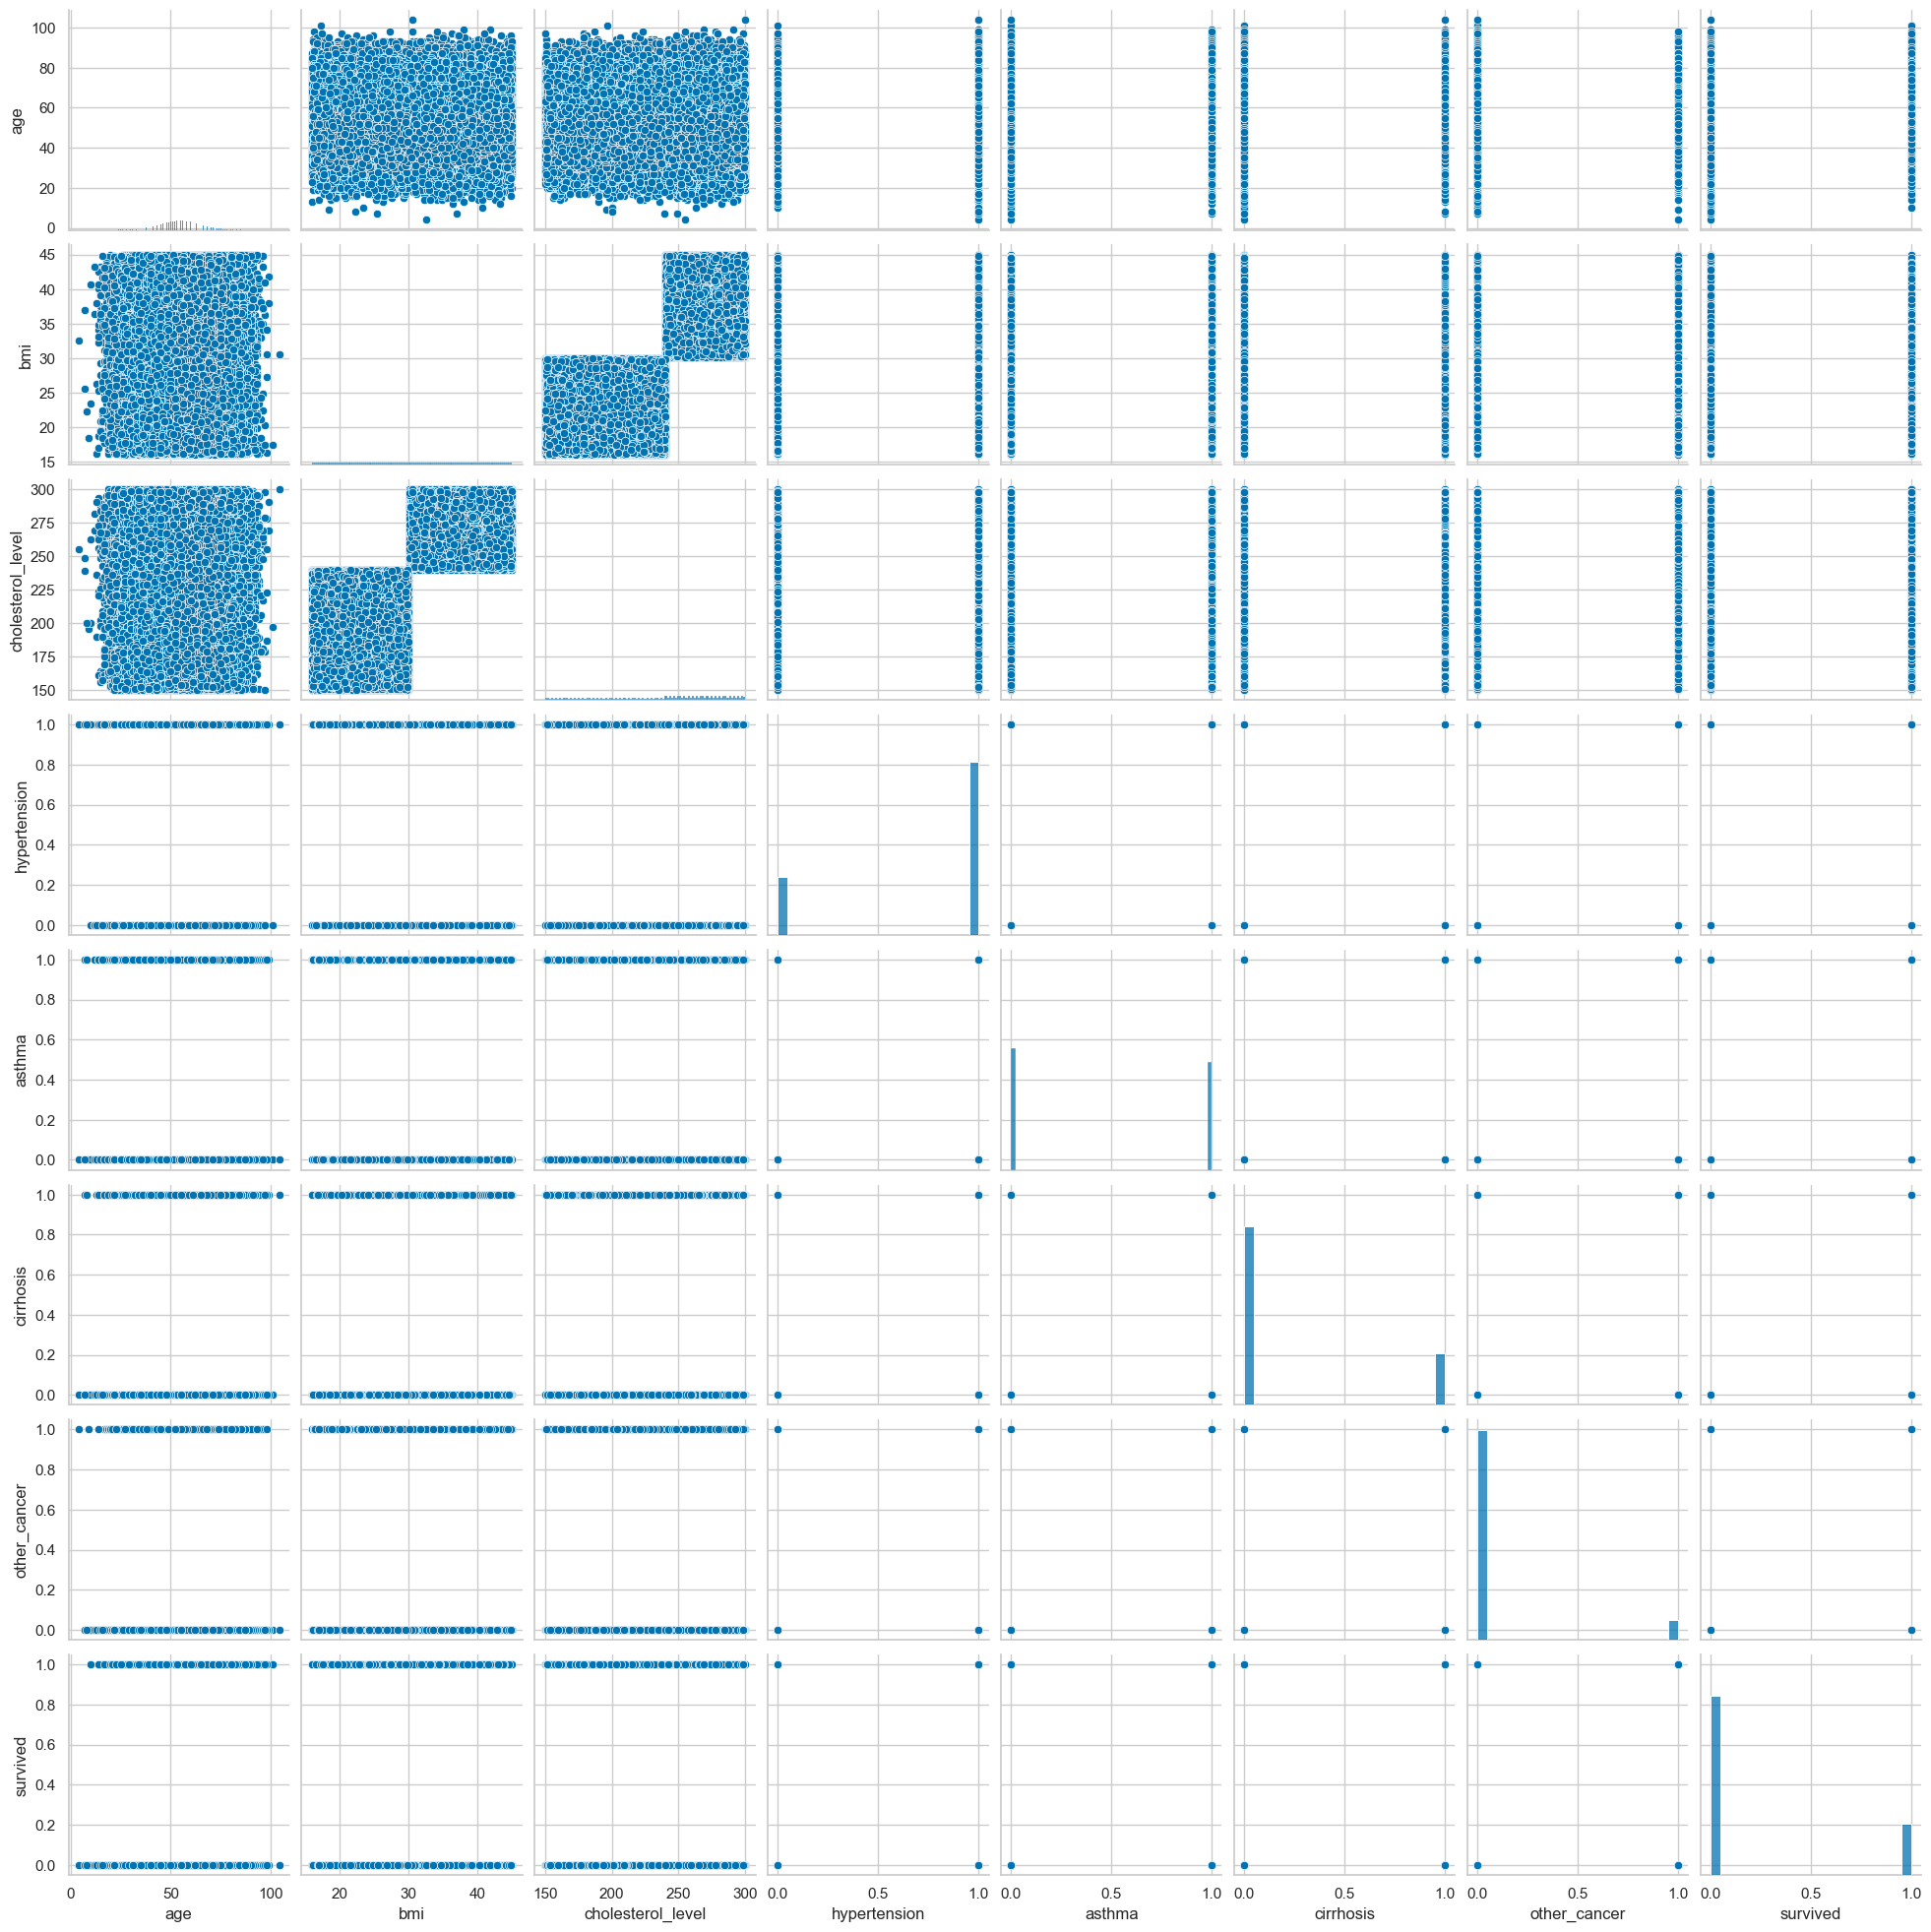

In [12]:
sns.pairplot(df)

In [18]:
def plot_numeric_vs_categoric(df, num_feature, cat_feature):
    plt.figure(figsize=(14, 6))

    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=cat_feature, y=num_feature, data=df)
    plt.title(f"{num_feature} distribution by {cat_feature}")
    plt.xticks(rotation=45)

    # Violinplot
    plt.subplot(1, 2, 2)
    sns.violinplot(x=cat_feature, y=num_feature, data=df)
    plt.title(f"{num_feature} distribution by {cat_feature}")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

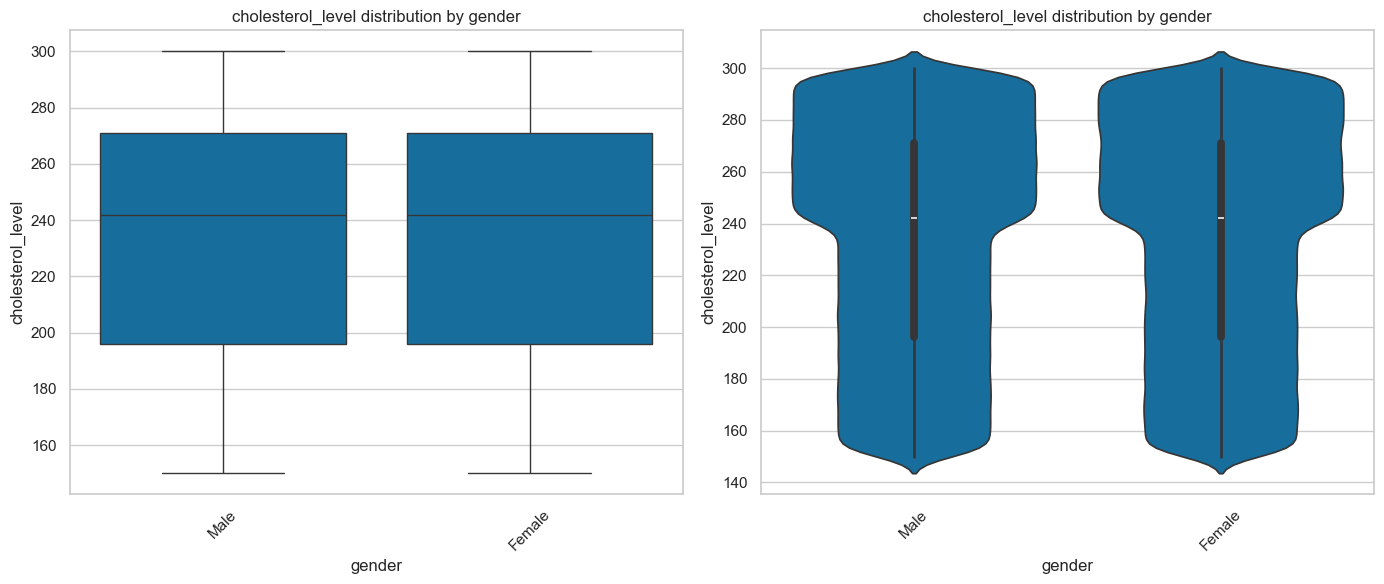

In [19]:
plot_numeric_vs_categoric(df, 'cholesterol_level', 'gender')

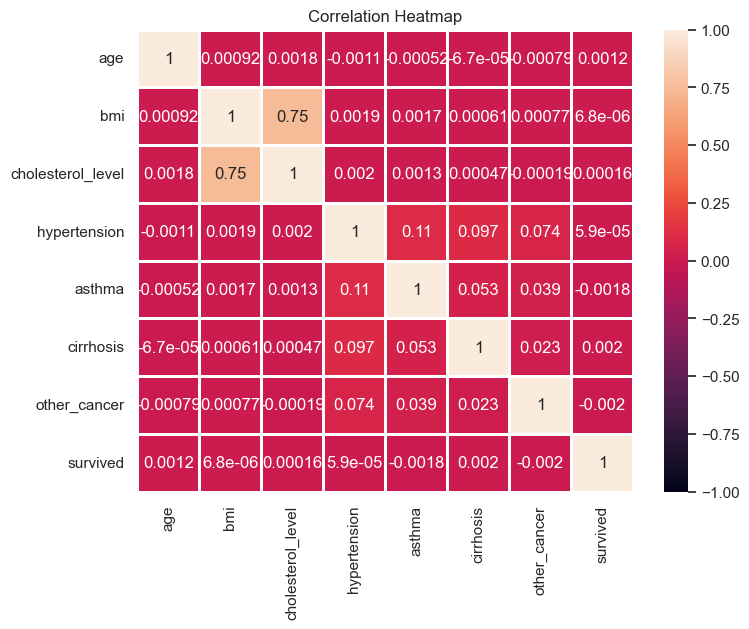

In [20]:
corr = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, linewidths=1)
plt.title(f"Correlation Heatmap")
plt.show()

#### Heatmap conclusions

So we can see a high correlation between cholestorol_level and bmi. This is something we would suspect as since BMI (Body mass index) is a measure of body fat relative to height and weight. Meaning individuals with a higher BMI often are associated with poor dietary habits, smoking, genetic predispostions, etc. 

Since cholestorol is the build up of fat in blood. Which clearly shows us that the greater the BMI the more fat is in an individuals blood, resulting in higher cholestorl levels.

However for modeling, these features are multicolinear meaning they carry redundant information. So for models like Logisitic Regression this may impact preformance. Suggesting we should either remove one of these features, combine them, use regularized models like Lasso Regression which can do feature selection for us, or use tree models which isnt affected by multicolinearity as much

Another major issue is that all of the features carry very little correlation in the target feature. Meaning the model is struggling to find any distinguishing patters in the data

### Target Analysis

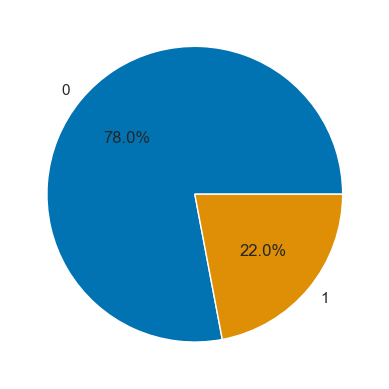

In [21]:
df['survived'].value_counts(normalize=True).plot.pie(autopct = '%1.1f%%')
plt.ylabel('')
plt.show()

So as we can see our classes is moderately imbalanced. Since we have many samples in the dataset we can use compare the preformance of the model without any balancing and with undersampling techniques

In [22]:
def target_analysis(df, features ,target = 'survived'):
    stats.probplot(df[target], dist='norm', plot=plt)
    plt.title("Probability Plot (Q-Q Plot)")
    plt.show()
    for feature in features:
        if feature != target:
            dtype = df[feature].dtype
            if dtype == 'int64' or dtype == 'float64':
                plt.figure(figsize=(12,8))
                
                sns.scatterplot(x = feature, y = target, data = df)
                plt.title(f"{feature} vs {target}")
    
                plt.tight_layout()
                plt.show()
            else:
                plt.figure(figsize=(12,8))
                
                plt.subplot(1,2,1)
                sns.boxplot(x=feature, y=target, data=df)
                plt.title(f"Boxplot of {feature} vs {target}")
    
                plt.subplot(1,2,2)
                sns.violinplot(x=feature, y=target, data=df)
                plt.title(f"violin of {feature} vs {target}")
    
                plt.tight_layout()
                plt.show()        

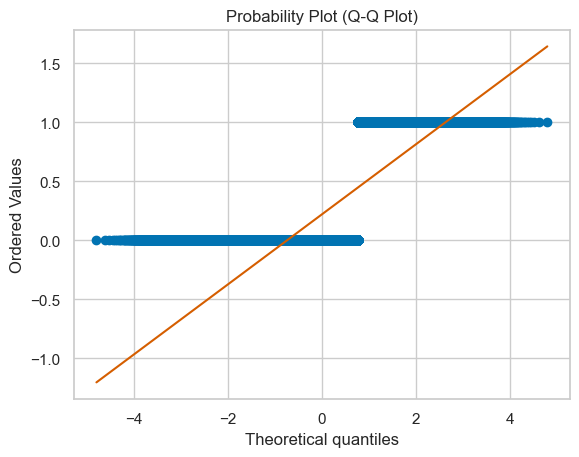

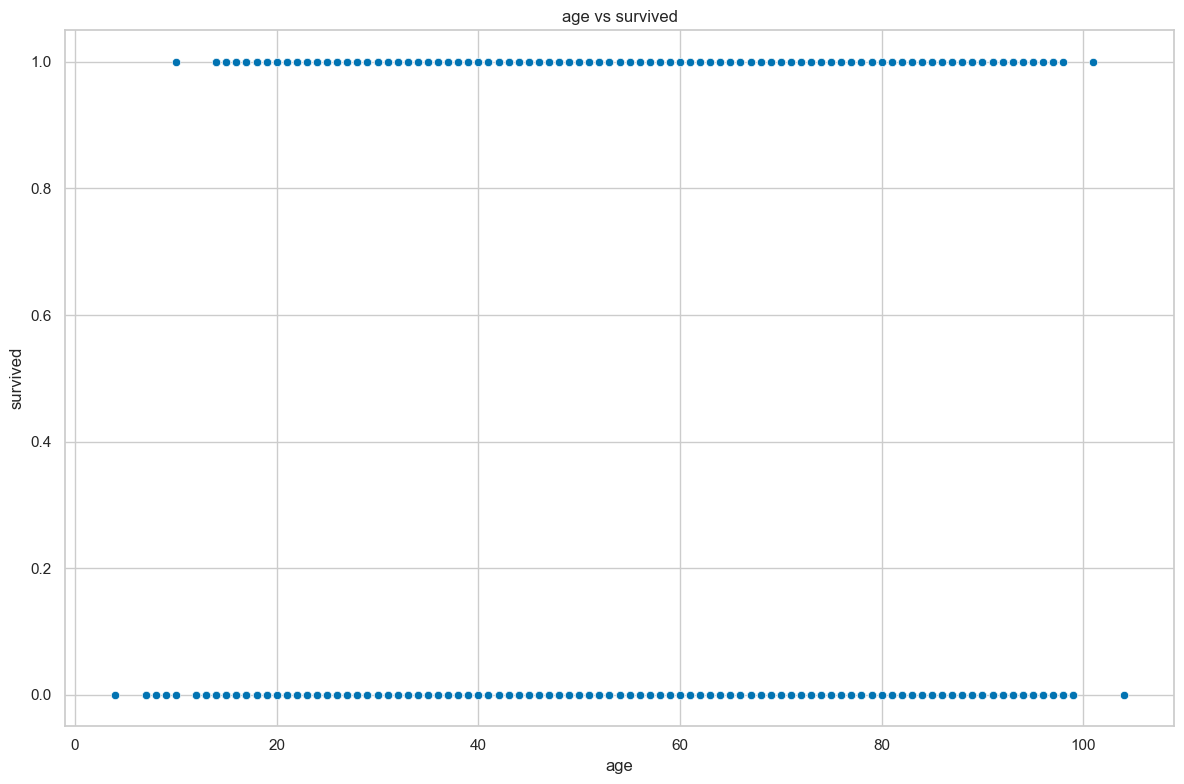

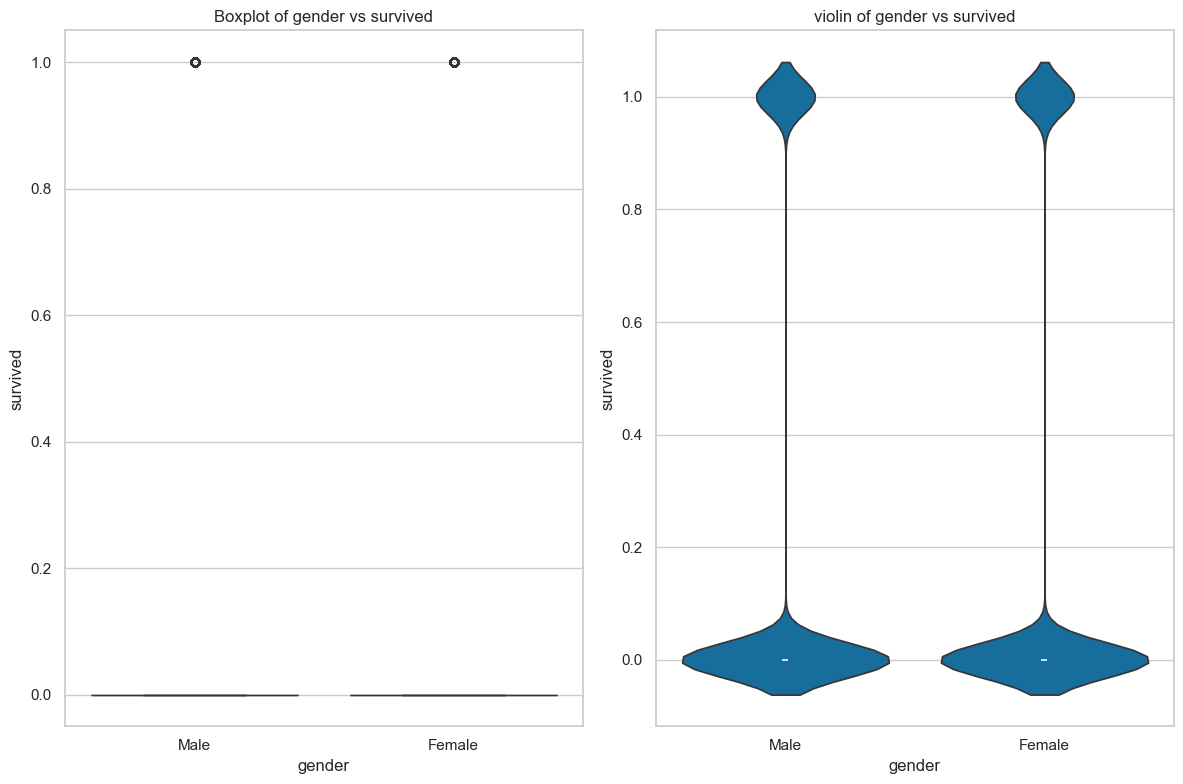

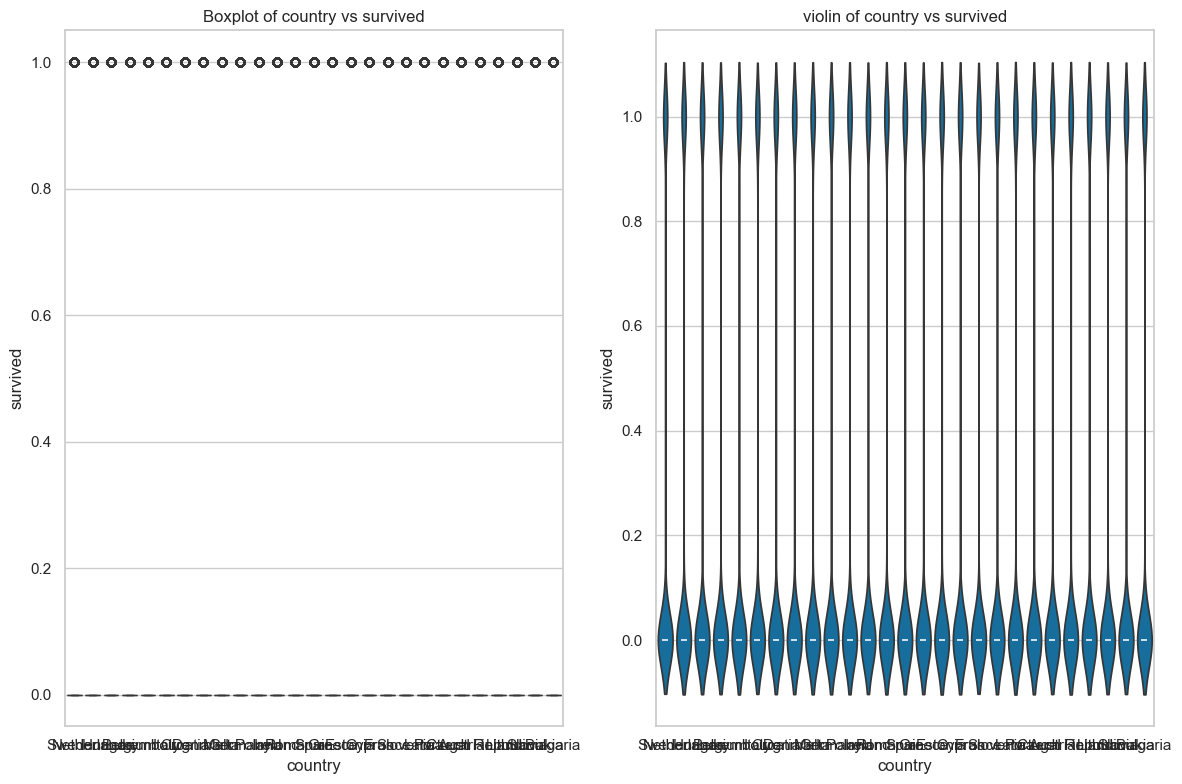

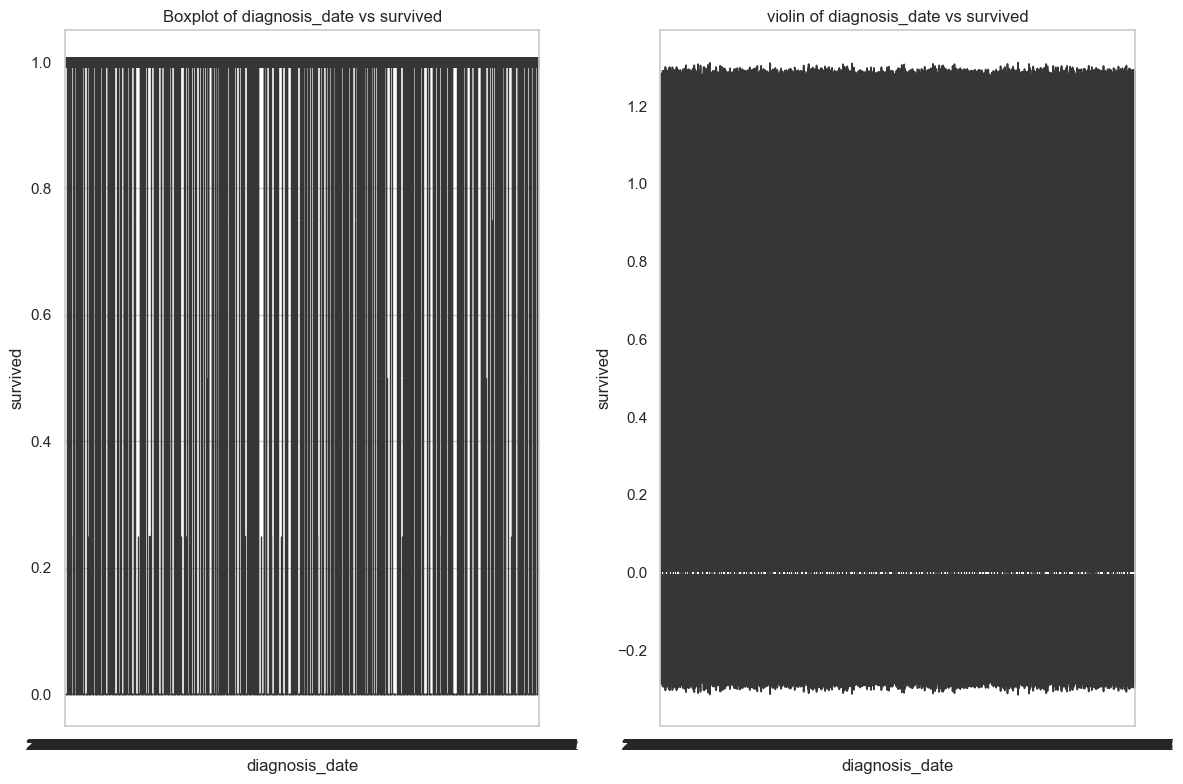

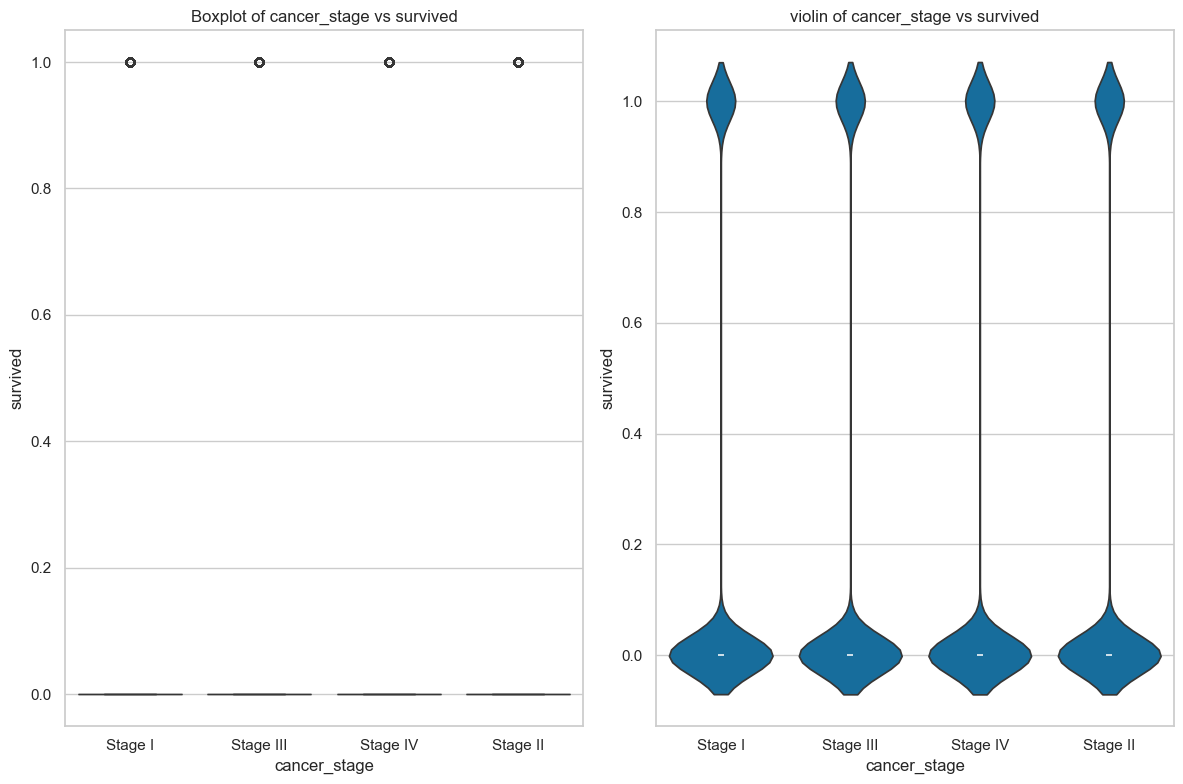

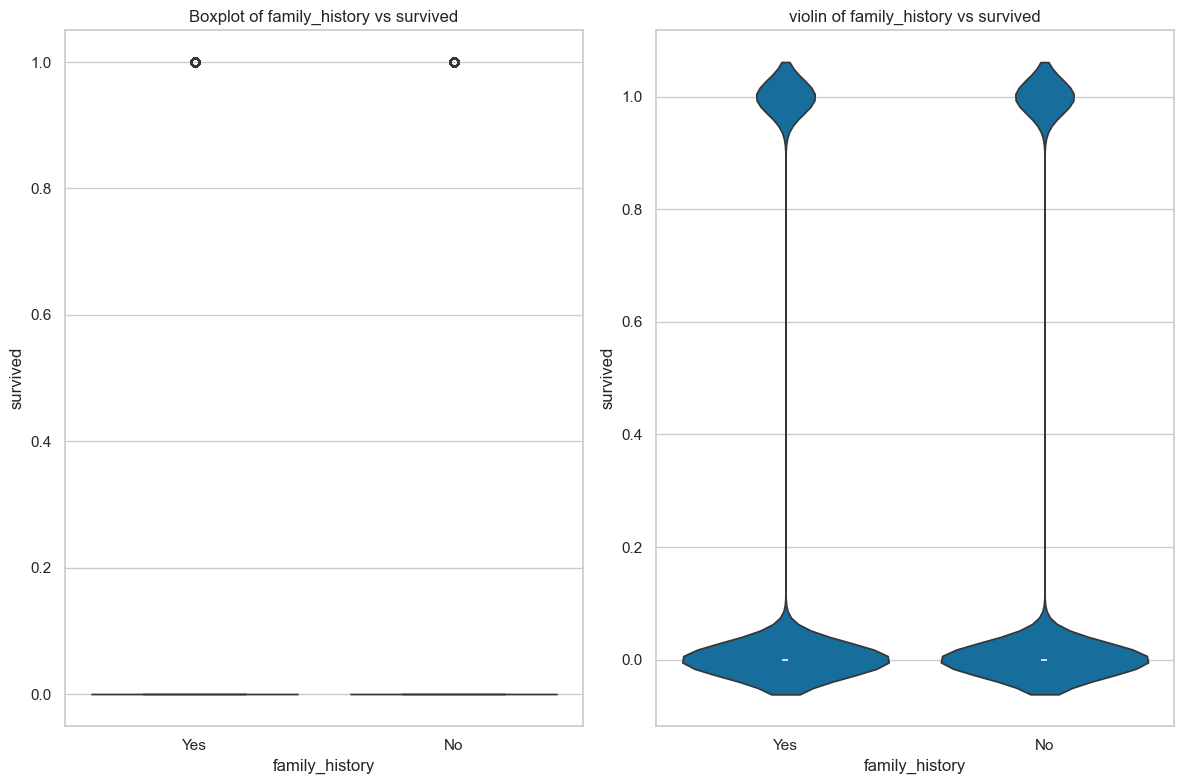

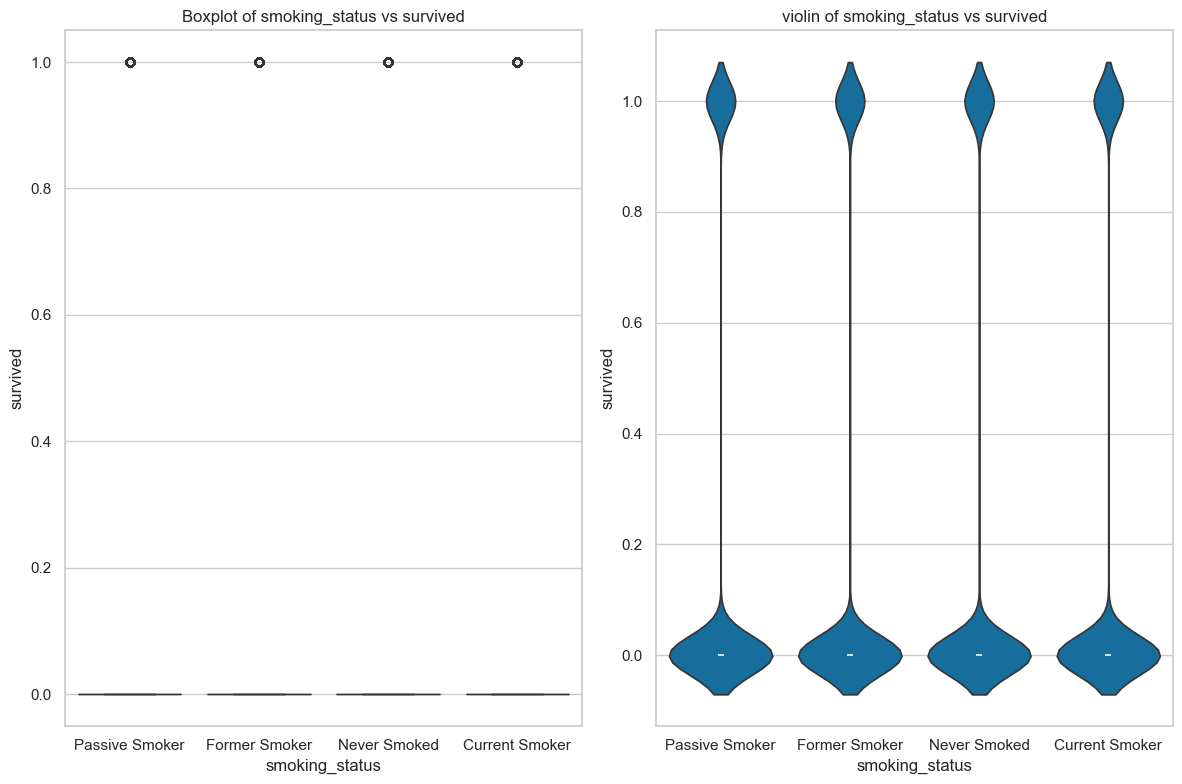

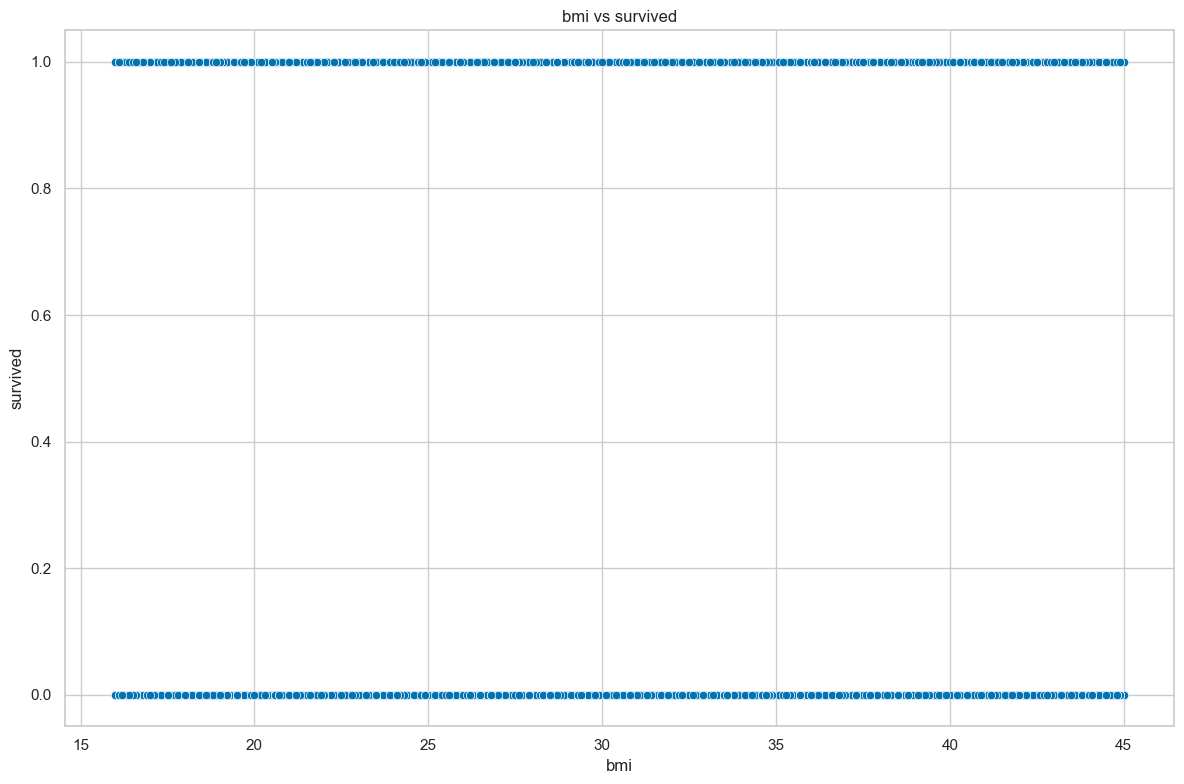

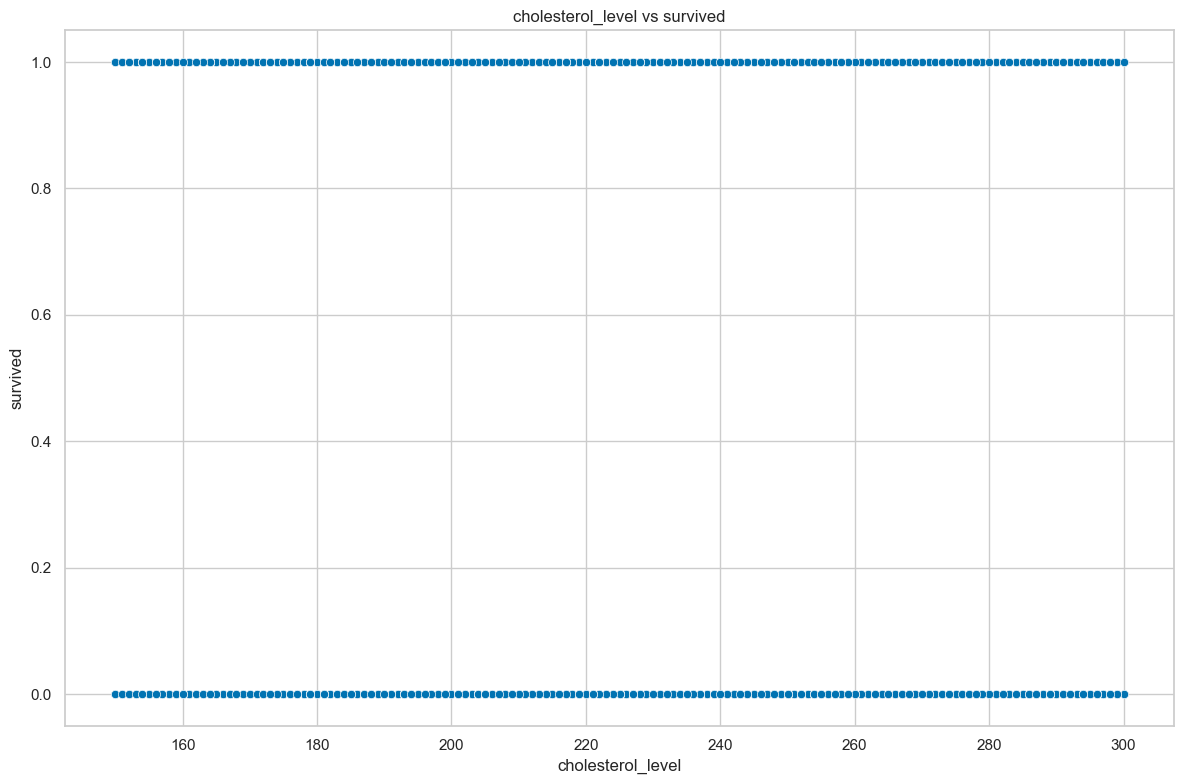

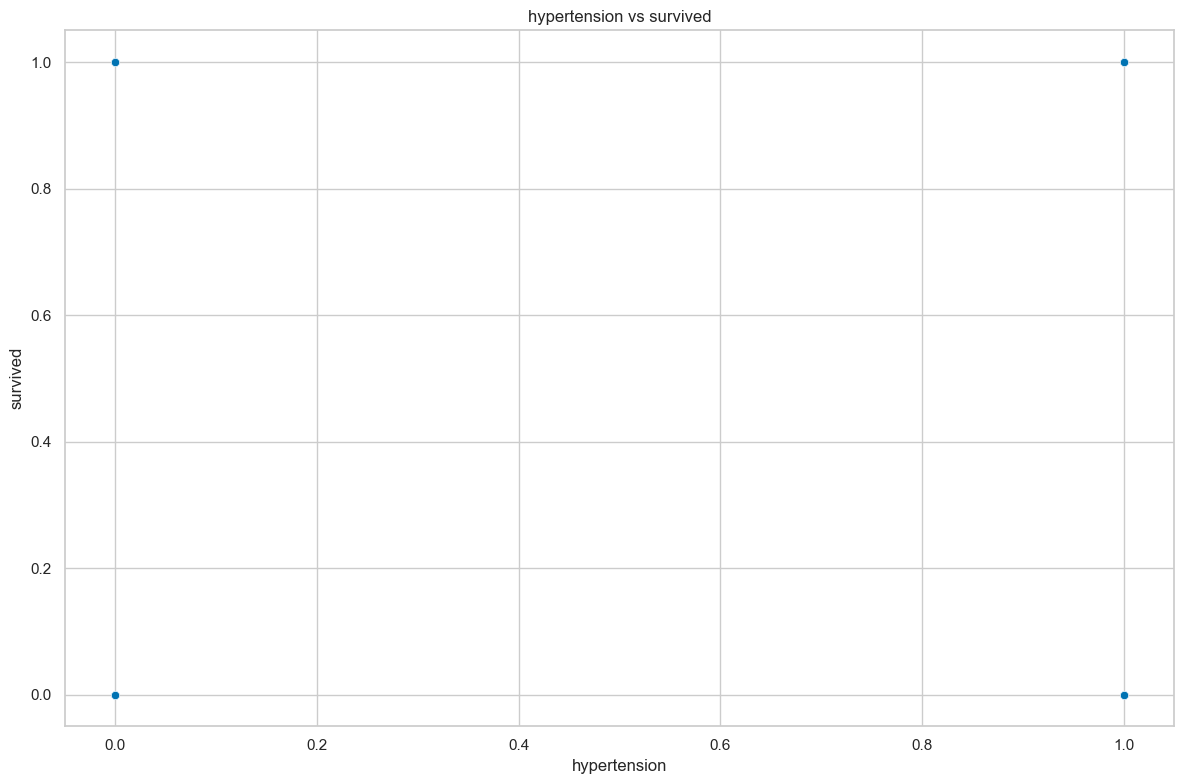

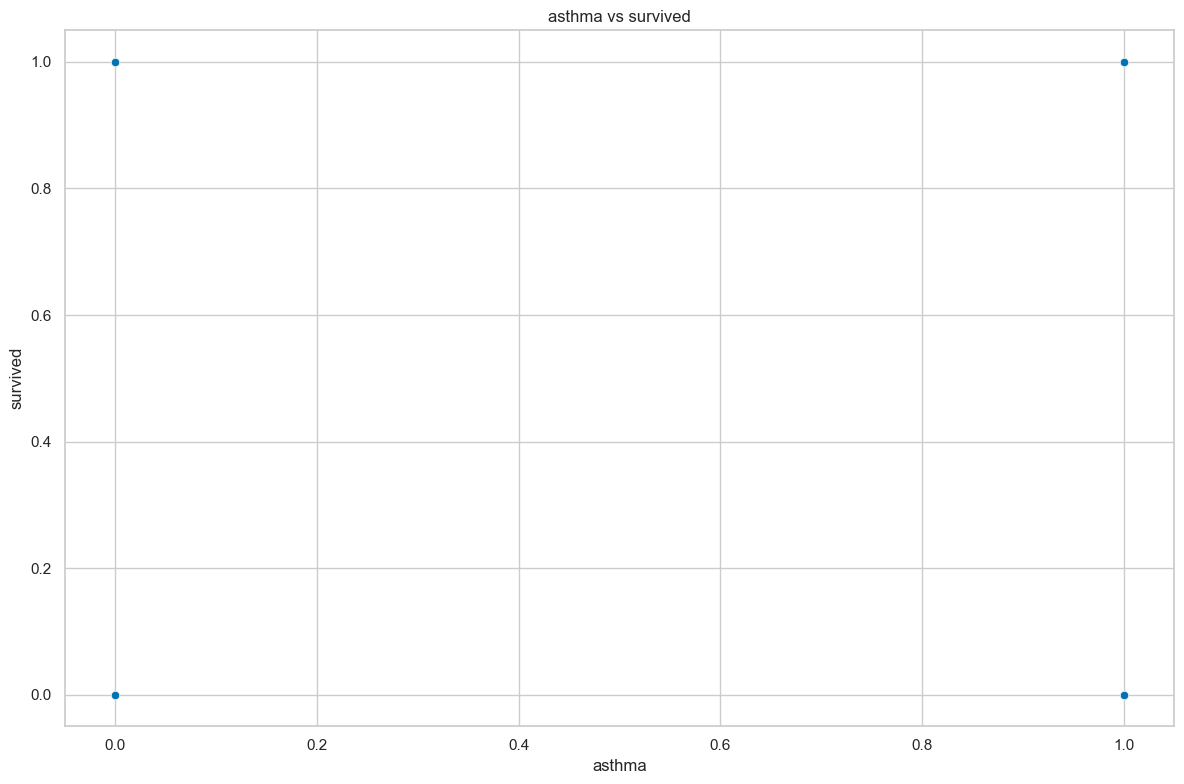

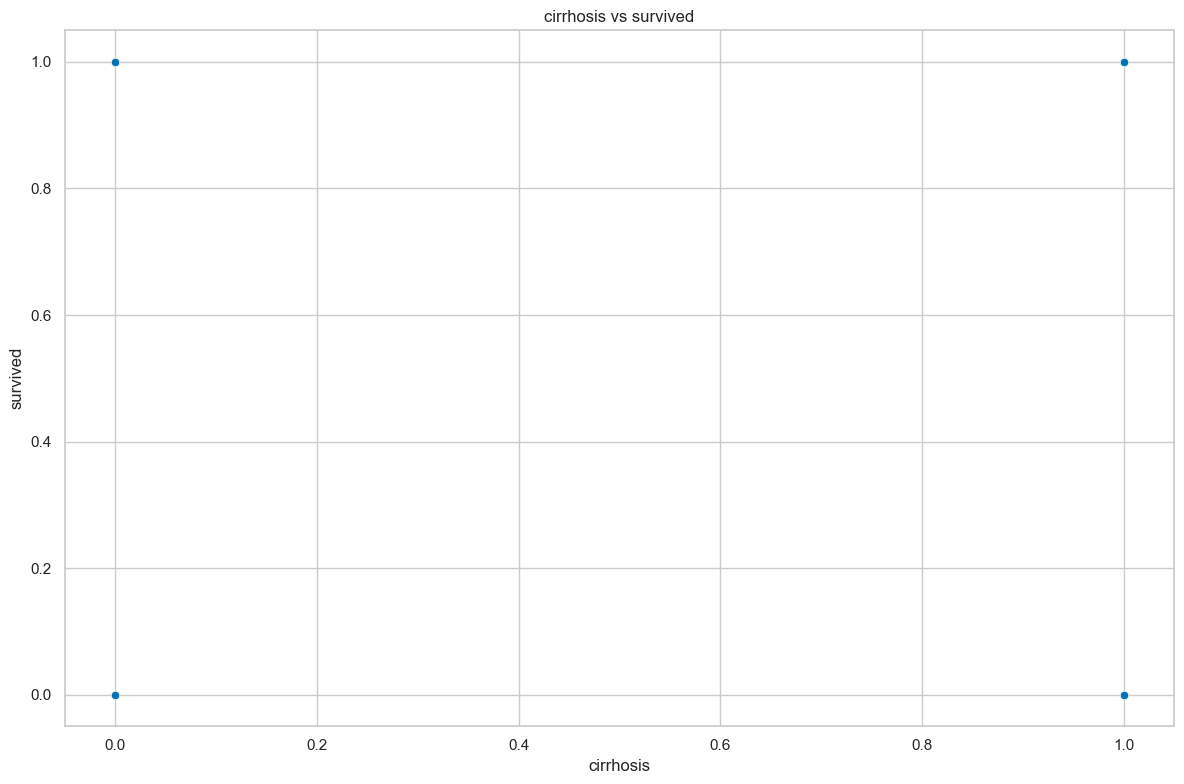

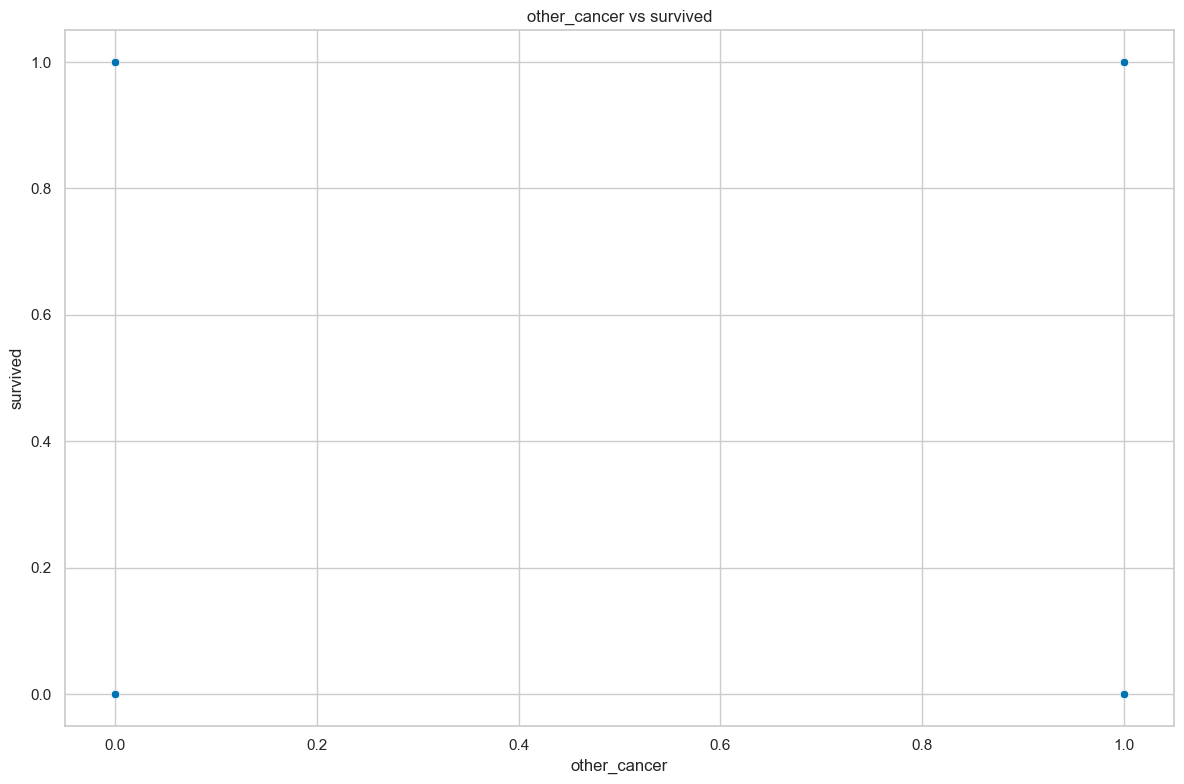

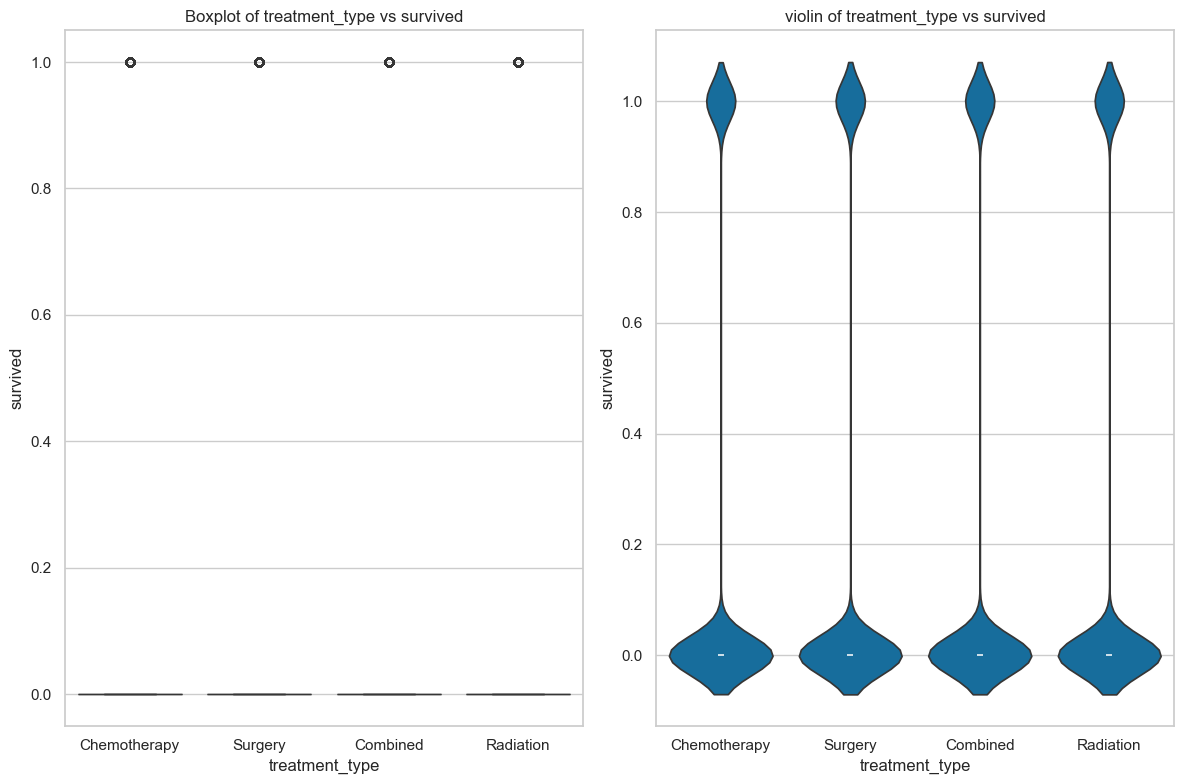

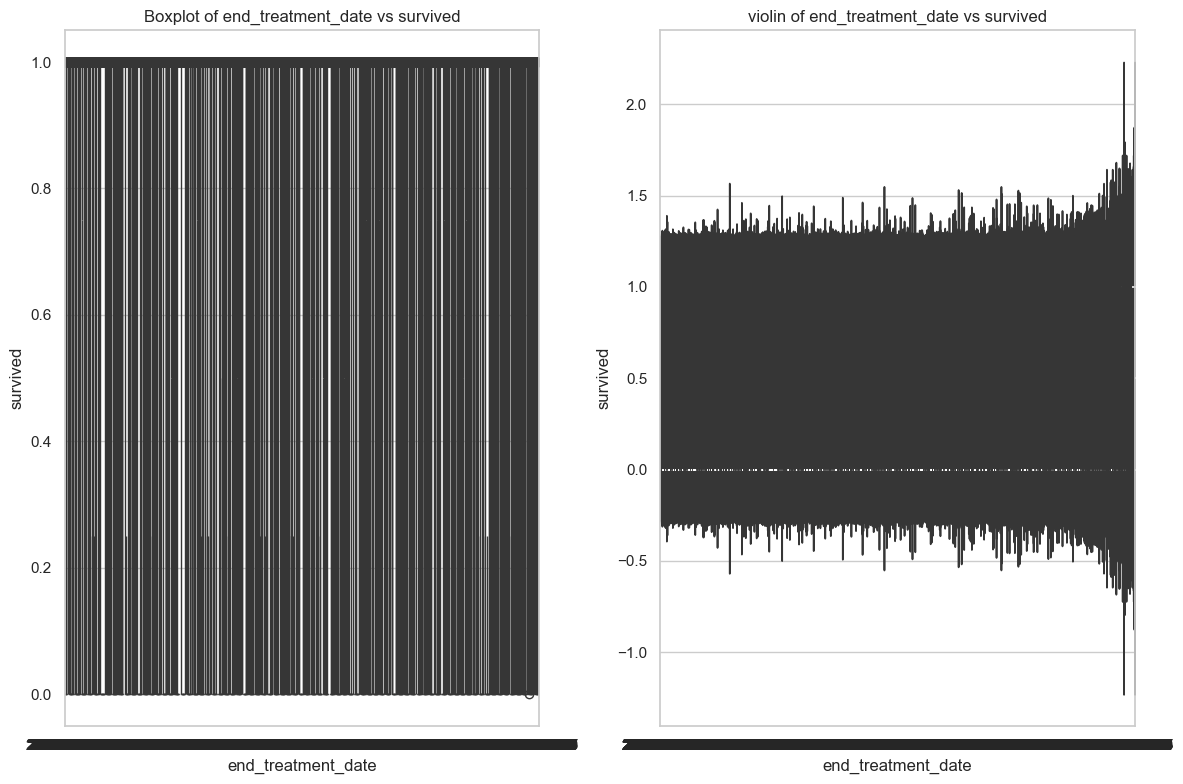

In [23]:
target_analysis(df,features)

#### Target Conclusions

- From the probability plot we can see the data is normally distributed
- Age is not a strong indicator of survival as wether a patients survives or not generally remains consistent amongst all ages, with younger ages having a better chance of survival
- BMI, and cholesterol level is also a weak indicator of a patients survival, across all cholestoral levels and BMI, survival is consistent
- Again we can see there arent any clear ways to distinguish classes from any of our features, suggesting we may need to create features or that the model may not be able to capture and hidden patterns.

#### Feature Engineering

In [78]:
df['diagnosis_date'] = pd.to_datetime(df['diagnosis_date'])
df['end_treatment_date'] = pd.to_datetime(df['end_treatment_date'])

df['treatment_time_days'] = (df['end_treatment_date'] - df['diagnosis_date']).dt.days

df = df.drop(['diagnosis_date','end_treatment_date','country'], axis = 1)

In [79]:
df['age_group'] = pd.cut(df['age'], bins=[0,30,45,60,75,100], labels=False)

In [80]:
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df['bmi_cat'] = df['bmi'].map(bmi_category)

In [81]:
df.head()

,age,gender,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,survived,treatment_time_days,age_group,bmi_cat
0,64.0,Male,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,0,523,3.0,Overweight
1,50.0,Female,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,1,424,2.0,Obese
2,65.0,Female,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,0,370,3.0,Obese
3,51.0,Female,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,0,443,2.0,Obese
4,37.0,Male,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,0,406,1.0,Normal


### Data preprocessing

The goal of this section is to,

1. Scale Numeric Features: For distance based and Gradient based models like Logisitc Regression, KNN, SVM scaling helps these models help the model remain consistent among all features
2. Encode Categorical Features

In [82]:
cat_df = df.select_dtypes(include=['object'])
cat_df.head()

,gender,cancer_stage,family_history,smoking_status,treatment_type,bmi_cat
0,Male,Stage I,Yes,Passive Smoker,Chemotherapy,Overweight
1,Female,Stage III,Yes,Passive Smoker,Surgery,Obese
2,Female,Stage III,Yes,Former Smoker,Combined,Obese
3,Female,Stage I,No,Passive Smoker,Chemotherapy,Obese
4,Male,Stage I,No,Passive Smoker,Combined,Normal


In [83]:
cat_df['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [84]:
cat_df['cancer_stage'].unique()

array(['Stage I', 'Stage III', 'Stage IV', 'Stage II'], dtype=object)

In [85]:
cat_df['family_history'].unique()

array(['Yes', 'No'], dtype=object)

In [86]:
cat_df['smoking_status'].unique()

array(['Passive Smoker', 'Former Smoker', 'Never Smoked',
       'Current Smoker'], dtype=object)

In [87]:
cat_df['treatment_type'].unique()

array(['Chemotherapy', 'Surgery', 'Combined', 'Radiation'], dtype=object)

#### Encoding Strategy
- For gender and family history, since these features are binary, we will map values to 1 and 0
- For cancer_stage and smoking_status since these features have clear order, we will encode these values using ordinal encoder
- For features without order, like treatment_type, apply One-Hot Encoding to create separate binary columns representing each category.

In [88]:
cat_df['gender'] = cat_df['gender'].map({'Male':1, 'Female':0})
cat_df['family_history'] = cat_df['family_history'].map({'Yes':1, 'No':0})

In [89]:
cancer_stages = ['Stage I','Stage II','Stage III','Stage IV']
smoking_status = ['Never Smoked','Former Smoker','Passive Smoker','Current Smoker']

ordinal_encoder = OrdinalEncoder(categories=[cancer_stages,smoking_status])
encoded_features = ordinal_encoder.fit_transform(cat_df[['cancer_stage','smoking_status']])

cat_df = cat_df.drop(['cancer_stage','smoking_status'], axis = 1)
cat_df['cancer_stage_encoded'] = encoded_features[:, 0]
cat_df['smoking_status_encoded'] = encoded_features[:, 1]

cat_df.head()

,gender,family_history,treatment_type,bmi_cat,cancer_stage_encoded,smoking_status_encoded
0,1,1,Chemotherapy,Overweight,0.0,2.0
1,0,1,Surgery,Obese,2.0,2.0
2,0,1,Combined,Obese,2.0,1.0
3,0,0,Chemotherapy,Obese,0.0,2.0
4,1,0,Combined,Normal,0.0,2.0


In [90]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Apply OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = ohe.fit_transform(cat_df[['treatment_type']])

# Get proper column names
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(['treatment_type']))

# Align index to avoid issues when merging
encoded_df.index = cat_df.index

# Concatenate original df with encoded features
cat_df = cat_df.drop('treatment_type', axis = 1)
cat_df = pd.concat([cat_df, encoded_df], axis=1)

cat_df.head()


,gender,family_history,bmi_cat,cancer_stage_encoded,smoking_status_encoded,treatment_type_Combined,treatment_type_Radiation,treatment_type_Surgery
0,1,1,Overweight,0.0,2.0,0.0,0.0,0.0
1,0,1,Obese,2.0,2.0,0.0,0.0,1.0
2,0,1,Obese,2.0,1.0,1.0,0.0,0.0
3,0,0,Obese,0.0,2.0,0.0,0.0,0.0
4,1,0,Normal,0.0,2.0,1.0,0.0,0.0


In [91]:
le = LabelEncoder()
cat_df['bmi_cat'] = le.fit_transform(cat_df['bmi_cat'])

In [92]:
cat_cols = df.select_dtypes(include=['object']).columns
df = pd.concat([df.drop(cat_cols,axis = 1),cat_df], axis = 1)

df.head()

,age,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,survived,treatment_time_days,age_group,gender,family_history,bmi_cat,cancer_stage_encoded,smoking_status_encoded,treatment_type_Combined,treatment_type_Radiation,treatment_type_Surgery
0,64.0,29.4,199,0,0,1,0,0,523,3.0,1,1,2,0.0,2.0,0.0,0.0,0.0
1,50.0,41.2,280,1,1,0,0,1,424,2.0,0,1,1,2.0,2.0,0.0,0.0,1.0
2,65.0,44.0,268,1,1,0,0,0,370,3.0,0,1,1,2.0,1.0,1.0,0.0,0.0
3,51.0,43.0,241,1,1,0,0,0,443,2.0,0,0,1,0.0,2.0,0.0,0.0,0.0
4,37.0,19.7,178,0,0,0,0,0,406,1.0,1,0,0,0.0,2.0,1.0,0.0,0.0


In [98]:
df['age_group'] = df['age_group'].fillna(df['age_group'].mean())

### Modeling

In [99]:

X = df.drop('survived', axis=1)
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train_ros_scaled = scaler.fit_transform(X_train_ros)
X_train_rus_scaled = scaler.fit_transform(X_train_rus)
X_test_scaled = scaler.transform(X_test) 

In [100]:
print("Before ROS:", np.bincount(y_train))
print("After RUS:", np.bincount(y_train_rus))
print("After ROS:", np.bincount(y_train_ros))

Before ROS: [555197 156803]
After RUS: [156803 156803]
After ROS: [555197 555197]


In [101]:
def eval_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', linewidths=0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # Classification Report
    print(f"\n{name} Metrics")
    print(classification_report(y_test, y_pred))

    # ROC and PR Curves
    plot_roc_curve(model, X_test, y_test, name)
    plot_pr_curve(model, X_test, y_test, name)

def plot_roc_curve(model, X_test, y_test, name):
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='b', label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{name} - ROC Curve")
    plt.legend()
    plt.show()

def plot_pr_curve(model, X_test, y_test, name):
    y_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    avg_precision = average_precision_score(y_test, y_probs)

    plt.figure(figsize=(10,6))
    plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
    plt.plot(thresholds, recall[:-1], label='Recall', color='orange')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"{name} - Precision-Recall vs Threshold")
    plt.legend()
    plt.grid()
    plt.show()


In [102]:
param_grid = {
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': [0.0, 0.5, 1.0],
    'C': [0.1, 1, 10],
    'max_iter': [100]
}

lr_random = RandomizedSearchCV(
    LogisticRegression(class_weight='balanced'),
    param_distributions=param_grid,
    scoring='precision',
    cv=3,
    n_jobs=-1,
)

lr_best = lr_random.fit(X_train_scaled, y_train)

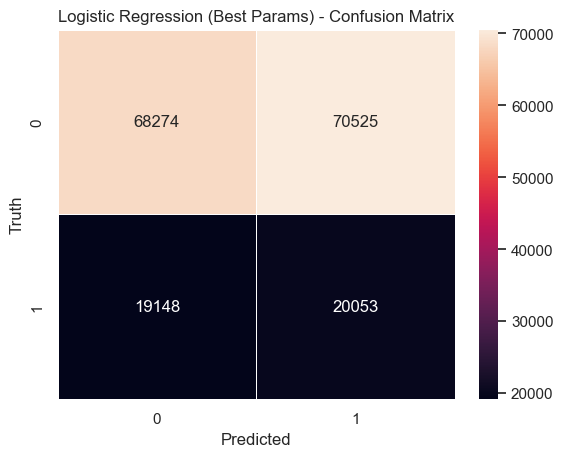


Logistic Regression (Best Params) Metrics
              precision    recall  f1-score   support

           0       0.78      0.49      0.60    138799
           1       0.22      0.51      0.31     39201

    accuracy                           0.50    178000
   macro avg       0.50      0.50      0.46    178000
weighted avg       0.66      0.50      0.54    178000



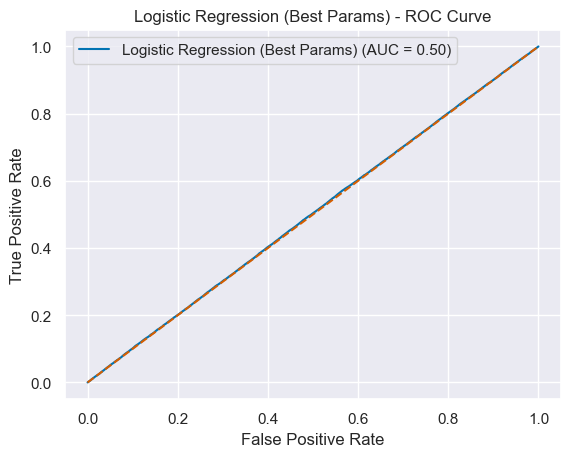

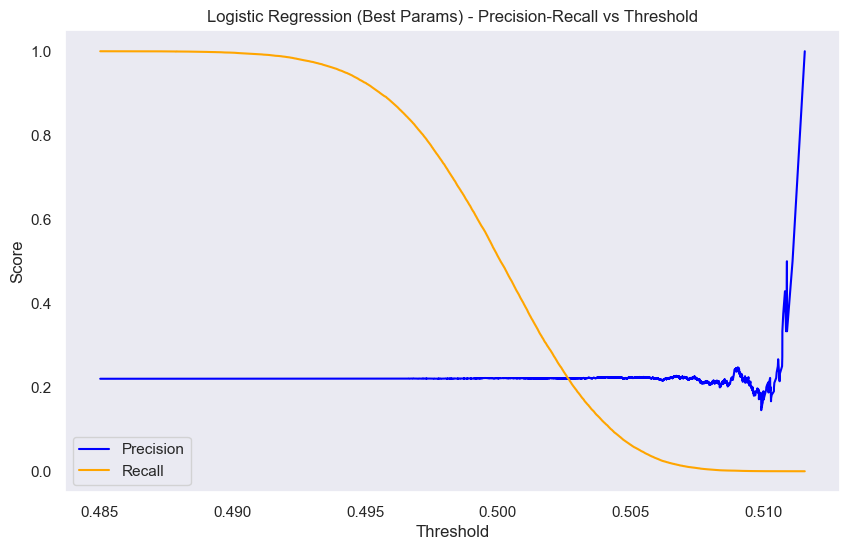

Best Params for Logisitc Regression: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 100, 'l1_ratio': 1.0, 'C': 0.1}


In [103]:
eval_model(lr_best, X_test_scaled, y_test, 'Logistic Regression (Best Params)')

print(f"Best Params for Logisitc Regression: {lr_best.best_params_}")

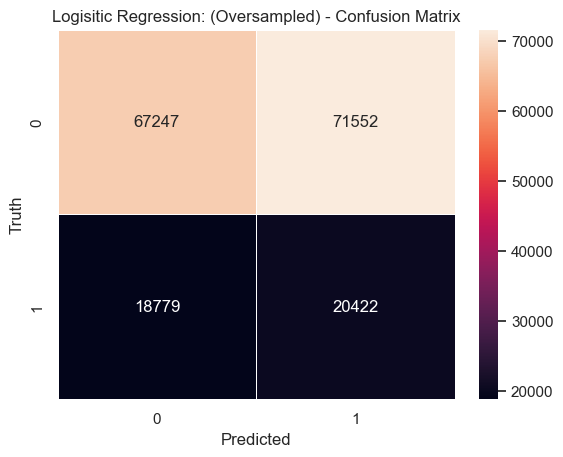


Logisitic Regression: (Oversampled) Metrics
              precision    recall  f1-score   support

           0       0.78      0.48      0.60    138799
           1       0.22      0.52      0.31     39201

    accuracy                           0.49    178000
   macro avg       0.50      0.50      0.45    178000
weighted avg       0.66      0.49      0.54    178000



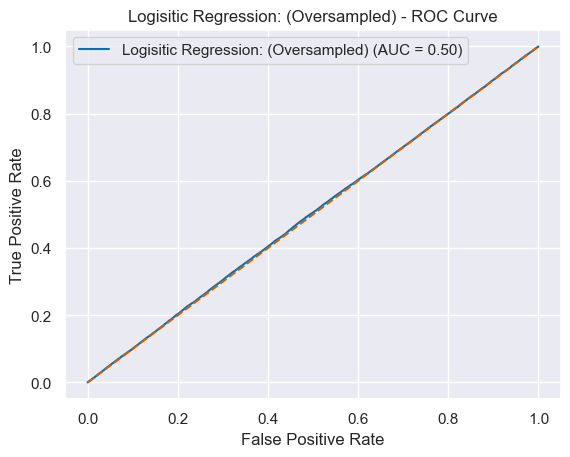

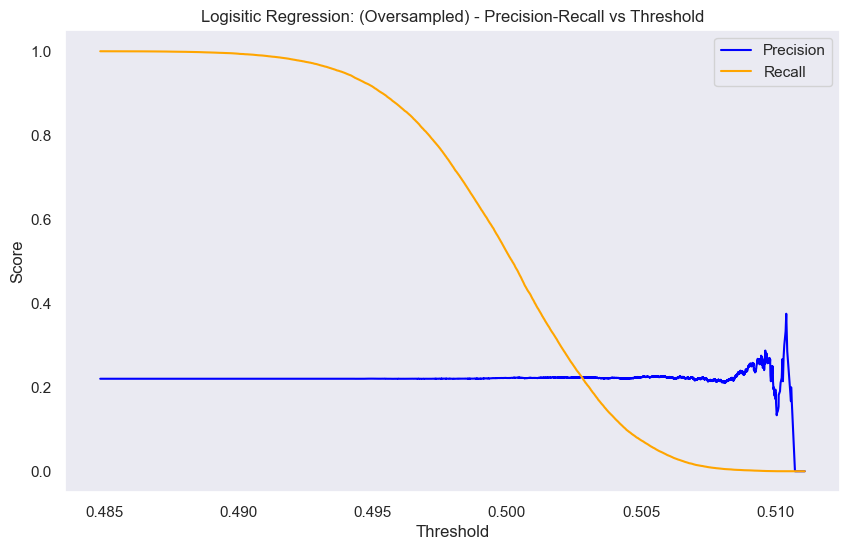

In [104]:
lr_best_ros = lr_best.fit(X_train_ros_scaled, y_train_ros)
eval_model(lr_best_ros, X_test_scaled,y_test, 'Logisitic Regression: (Oversampled)')

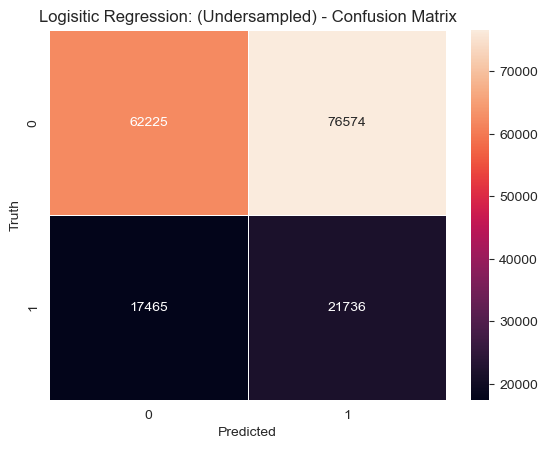


Logisitic Regression: (Undersampled) Metrics
              precision    recall  f1-score   support

           0       0.78      0.45      0.57    138799
           1       0.22      0.55      0.32     39201

    accuracy                           0.47    178000
   macro avg       0.50      0.50      0.44    178000
weighted avg       0.66      0.47      0.51    178000



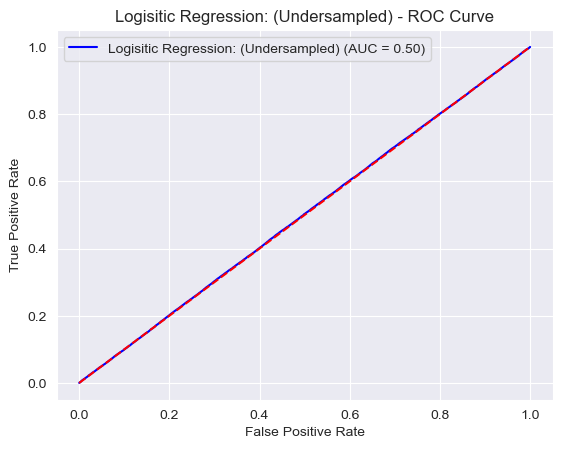

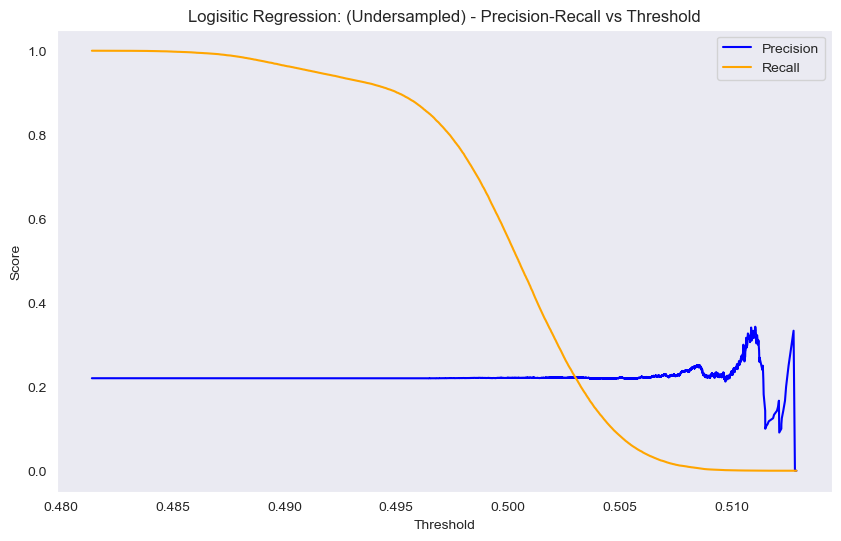

In [23]:
lr_best_rus = lr_best.fit(X_train_rus_scaled,y_train_rus)
eval_model(lr_best_rus, X_test_scaled,y_test, 'Logisitic Regression: (Undersampled)')

#### Logsitic Regression Model Preformance

So what we see across all three models is that the accuracy,F1-score, Recall, and Precision remained consistent. Suggesting that the model isnt struggling with an imbalance, rather it is struggling with seperating survived and not survived classes.

In [105]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
)
xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

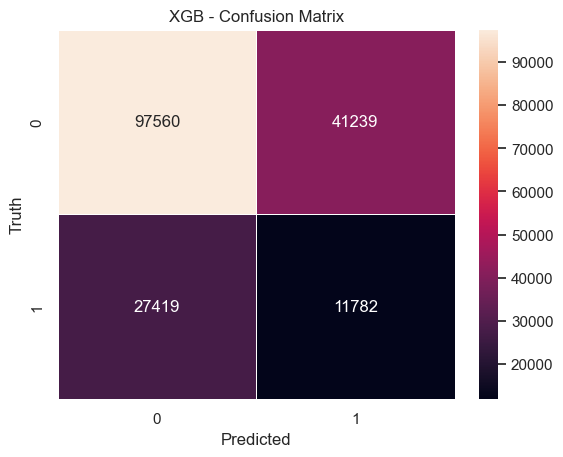


XGB Metrics
              precision    recall  f1-score   support

           0       0.78      0.70      0.74    138799
           1       0.22      0.30      0.26     39201

    accuracy                           0.61    178000
   macro avg       0.50      0.50      0.50    178000
weighted avg       0.66      0.61      0.63    178000



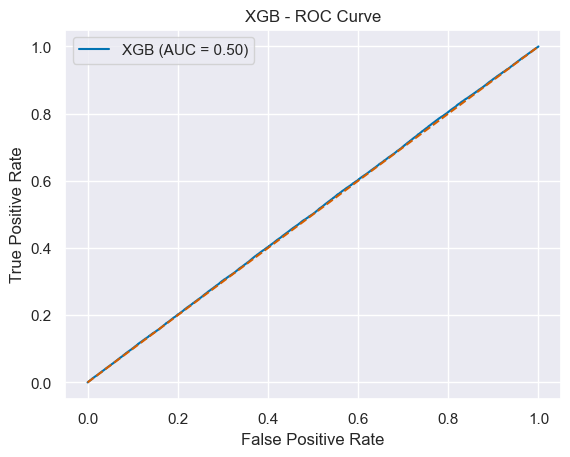

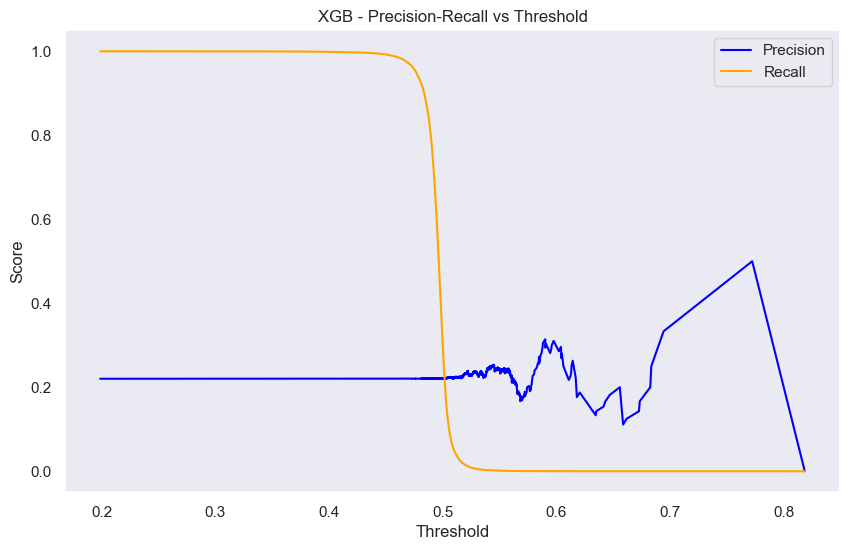

In [106]:
eval_model(xgb, X_test_scaled, y_test, 'XGB')

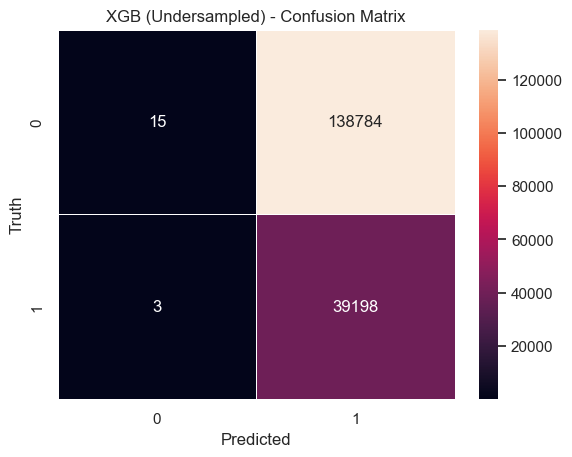


XGB (Undersampled) Metrics
              precision    recall  f1-score   support

           0       0.83      0.00      0.00    138799
           1       0.22      1.00      0.36     39201

    accuracy                           0.22    178000
   macro avg       0.53      0.50      0.18    178000
weighted avg       0.70      0.22      0.08    178000



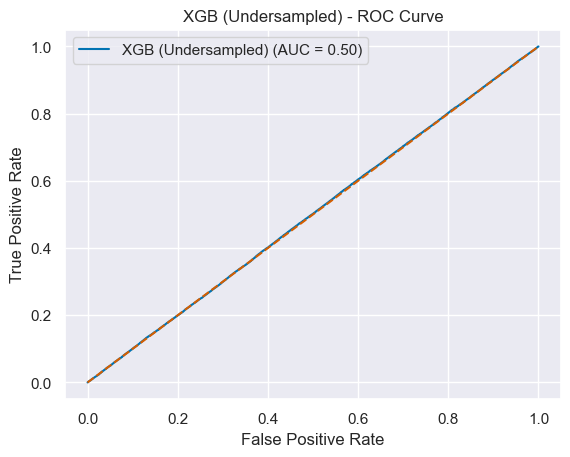

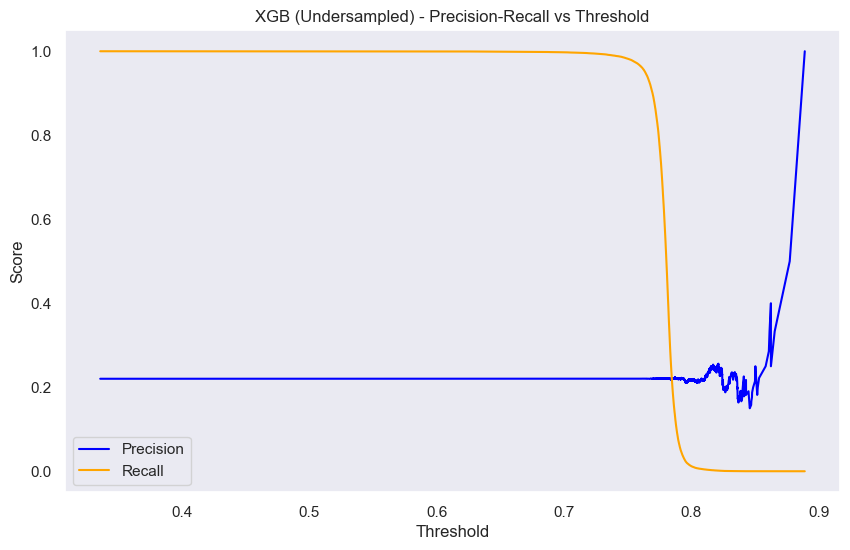

In [107]:
xgb_rus = xgb.fit(X_train_rus_scaled, y_train_rus)
eval_model(xgb_rus, X_test_scaled, y_test, 'XGB (Undersampled)')

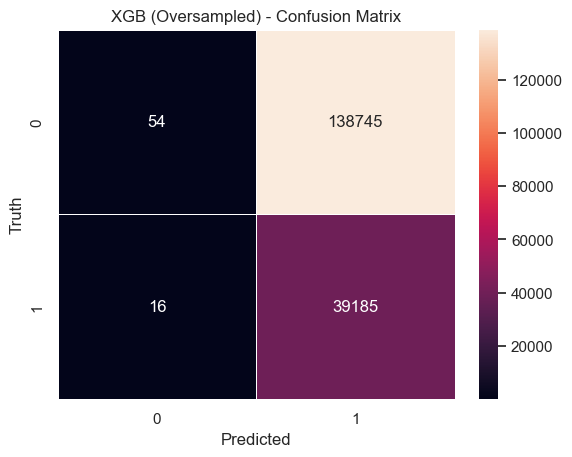


XGB (Oversampled) Metrics
              precision    recall  f1-score   support

           0       0.77      0.00      0.00    138799
           1       0.22      1.00      0.36     39201

    accuracy                           0.22    178000
   macro avg       0.50      0.50      0.18    178000
weighted avg       0.65      0.22      0.08    178000



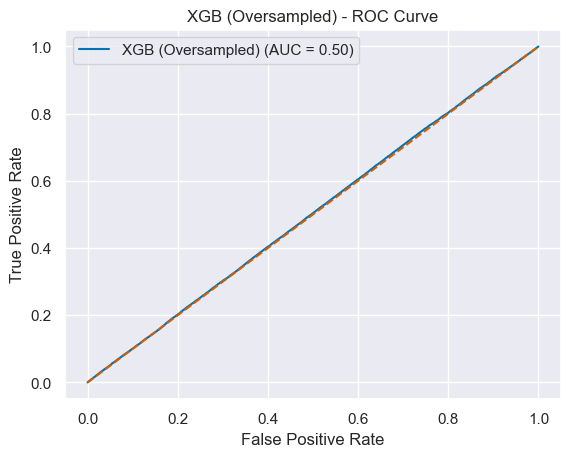

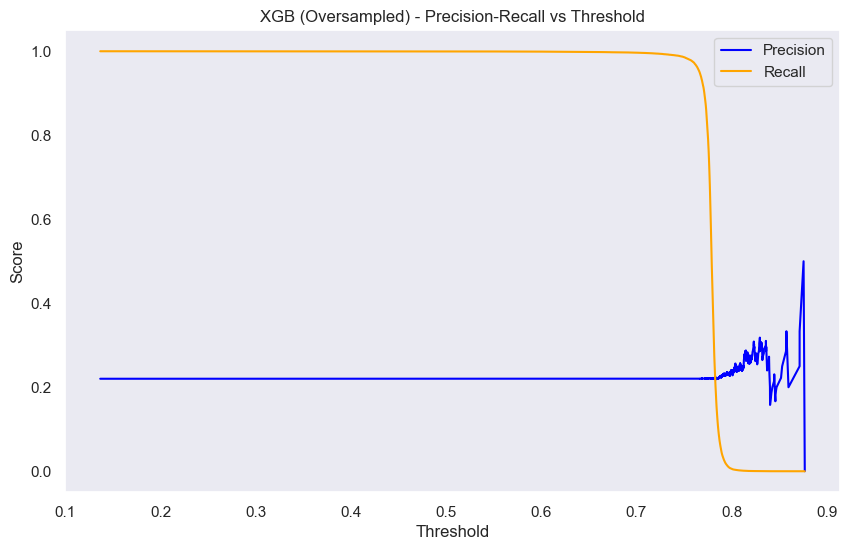

In [108]:
xgb_ros = xgb.fit(X_train_ros_scaled, y_train_ros)
eval_model(xgb_ros, X_test_scaled, y_test, 'XGB (Oversampled)')

#### XGB Analysis

Something interesting we see here is when XBG is trained on the normal scaled data, it preforms better than the logisitc regression models, but still struggles with differentiating class 0 and 1. When we train using the rus and ros sets,the models preformance switches to differentating class 1 better.

What we can now try is stacking models to see if the wisdom of the croud approach may result in better preformance

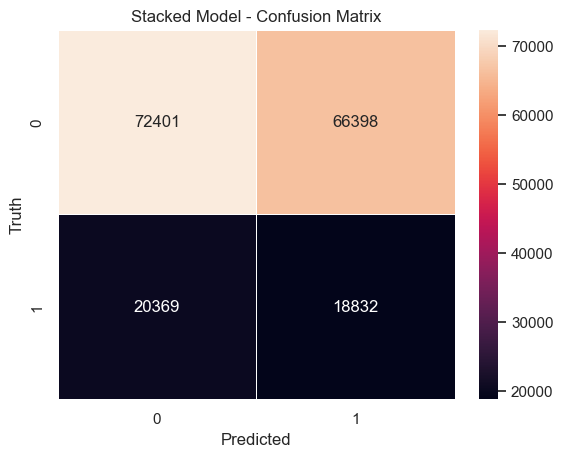


Stacked Model Metrics
              precision    recall  f1-score   support

           0       0.78      0.52      0.63    138799
           1       0.22      0.48      0.30     39201

    accuracy                           0.51    178000
   macro avg       0.50      0.50      0.46    178000
weighted avg       0.66      0.51      0.55    178000



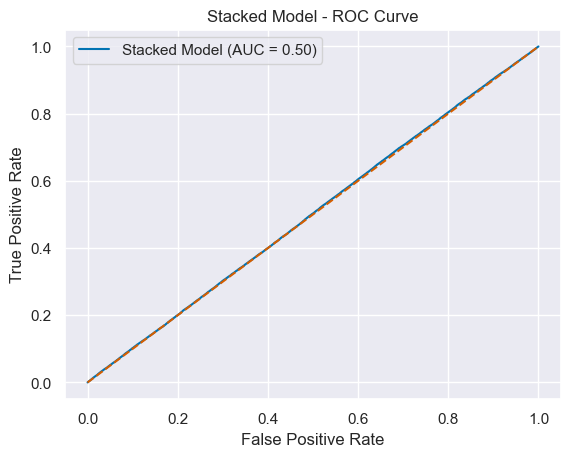

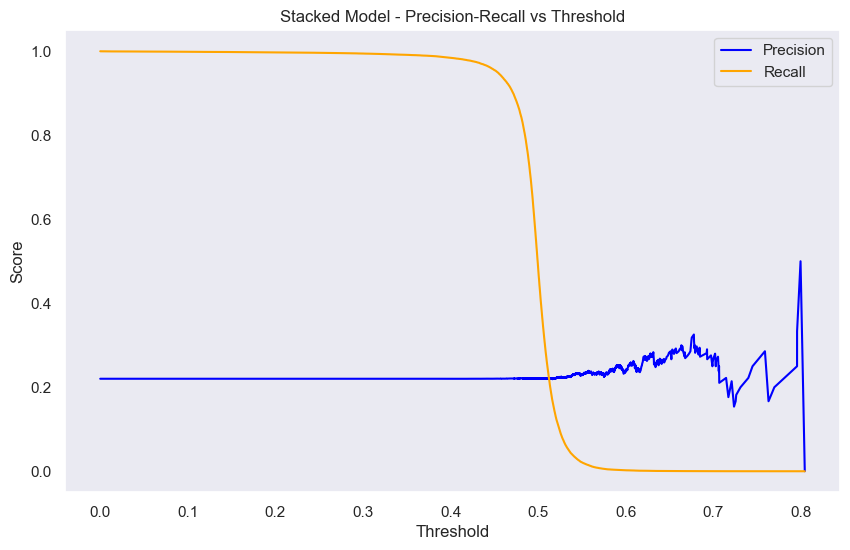

In [111]:
stack = StackingClassifier(
    estimators=[
        ('xgb', xgb_ros),
        ('lr', lr_best_ros)
    ],
    final_estimator=LogisticRegression()
)

stack.fit(X_train_ros_scaled, y_train_ros)

eval_model(stack, X_test_scaled, y_test, 'Stacked Model')


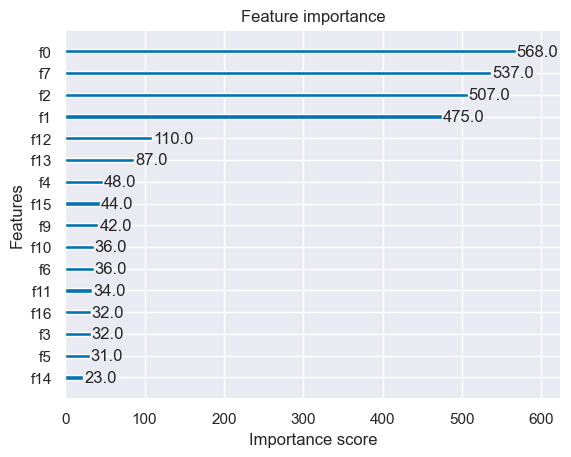

In [113]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb_ros)
plt.show()


The stacking model improves the balance between classes compared to simpler models but still struggles with the minority class’s precision and recall.

### Conclusions

Across all models and parameter settings tested, the performance indicates difficulty in accurately distinguishing between the classes. This challenge likely stems from weak or insufficient correlations between the available features and the target variable, limiting the models’ ability to learn meaningful patterns for reliable classification.